# Cálculo de Producción de Hidrógeno Verde por Punto en la Grilla usando Calliope

Este notebook calcula la **producción de hidrógeno verde (H2V)** punto por punto en la grilla del Valle de Aconcagua, usando:
- **Calliope** para modelar el sistema energético completo (PV → Electrolyzer → Storage → Demand)
- Datos de Capacity Factor fotovoltaico (PV CF) por punto de grilla
- Optimización económica para cada punto espacial
- Validación espacial de resultados para años seleccionados

## Metodología con Calliope
1. **Cargar modelo Calliope** con configuración del sistema H2V
2. **Iterar sobre puntos de grilla** (lat, lon) con sus respectivos PV CF
3. **Optimizar sistema** para cada punto (capacidades óptimas PV/Electrolyzer/Storage)
4. **Extraer métricas**: H2 producido, consumo agua, LCOH, capacidades
5. **Validación espacial**: Mapas y estadísticas por escenario y año

## 1. Configuración e Imports

In [9]:
import calliope
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
import sys
warnings.filterwarnings('ignore')

# Importar utilidades propias de Calliope
sys.path.append('/home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope_v6')
from utils_calliope import compute_kpis

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"✓ Calliope version: {calliope.__version__}")

✓ Calliope version: 0.6.10


In [13]:
# Rutas del proyecto
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
CALLIOPE_DIR = BASE_DIR / 'scripts' / 'calliope_v6'
DATA_DIR = BASE_DIR / 'data'
PV_CF_DIR = DATA_DIR / 'pv_cf' / 'netcdf'
OUTPUT_DIR = DATA_DIR / 'h2v_production_spatial'
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Rutas de Calliope
MODEL_CONFIG = CALLIOPE_DIR / 'model_config.yml'
DEMAND_H2_CSV = CALLIOPE_DIR / 'data' / 'demand_h2_monthly_MWh.csv'

# Escenarios a procesar
SCENARIOS = ['ssp245', 'ssp370', 'ssp585']

# Parámetros de referencia (desde techs.yml)
ELECTROLYZER_PARAMS = {
    'efficiency_hhv': 0.68,              # HHV (techs.yml)
    'sec_h2': 50.0,                      # kWh_e/kg_H2 
    'water_consumption': 9.0,            # litros/kg_H2
    'capex': 900000,                     # $/MW_e
    'opex_annual': 25000,                # $/MW_e/año
    'lifetime': 15,                      # años
}

PV_PARAMS = {
    'capex': 700000,                     # $/MW
    'opex_annual': 15000,                # $/MW/año
    'lifetime': 25,                      # años
}

# Año de test para análisis inicial
TEST_YEAR = 2030

print("✓ Configuración completada")
print(f"\nRutas:")
print(f"  - Calliope dir: {CALLIOPE_DIR}")
print(f"  - PV CF dir: {PV_CF_DIR}")
print(f"  - Output dir: {OUTPUT_DIR}")
print(f"  - Model config: {MODEL_CONFIG.exists()}")
print(f"  - Demand H2: {DEMAND_H2_CSV.exists()}")
print(f"\nEscenarios: {', '.join(SCENARIOS)}")
print(f"Año de test: {TEST_YEAR}")

✓ Configuración completada

Rutas:
  - Calliope dir: /home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope_v6
  - PV CF dir: /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/netcdf
  - Output dir: /home/aninotna/magister/tesis/justh2_pipeline/data/h2v_production_spatial
  - Model config: True
  - Demand H2: True

Escenarios: ssp245, ssp370, ssp585
Año de test: 2030


## 3. Carga de Datos PV CF

In [5]:
# Explorar la estructura de los archivos NetCDF de PV CF
print("Explorando archivos NetCDF en:", PV_CF_DIR)
print("="*80)

# Cargar un archivo de ejemplo para ver su estructura
example_file = PV_CF_DIR / 'pv_cf_ssp245.nc'
if example_file.exists():
    print(f"\n📂 Archivo de ejemplo: {example_file.name}")
    print("-"*80)
    
    ds_example = xr.open_dataset(example_file)
    print("\n🔍 ESTRUCTURA DEL DATASET:")
    print(ds_example)
    
    print("\n\n📊 DIMENSIONES:")
    for dim, size in ds_example.dims.items():
        print(f"  {dim}: {size}")
    
    print("\n\n📝 VARIABLES:")
    for var in ds_example.data_vars:
        print(f"  {var}: {ds_example[var].dims} - {ds_example[var].shape}")
        if hasattr(ds_example[var], 'long_name'):
            print(f"    Descripción: {ds_example[var].long_name}")
        if hasattr(ds_example[var], 'units'):
            print(f"    Unidades: {ds_example[var].units}")
    
    print("\n\n📍 COORDENADAS:")
    print(f"  Latitudes: {ds_example.lat.min().values:.4f} a {ds_example.lat.max().values:.4f} ({len(ds_example.lat)} puntos)")
    print(f"  Longitudes: {ds_example.lon.min().values:.4f} a {ds_example.lon.max().values:.4f} ({len(ds_example.lon)} puntos)")
    print(f"  Tiempo: {pd.to_datetime(ds_example.time.values[0])} a {pd.to_datetime(ds_example.time.values[-1])} ({len(ds_example.time)} timesteps)")
    
    print("\n\n📈 ESTADÍSTICAS DE UNA VARIABLE:")
    # Identificar variable principal
    if 'cf_monthly' in ds_example:
        var_name = 'cf_monthly'
    elif 'capacity_factor' in ds_example:
        var_name = 'capacity_factor'
    else:
        var_name = list(ds_example.data_vars)[0]
    
    print(f"  Variable: {var_name}")
    var_data = ds_example[var_name]
    print(f"  Mínimo: {float(var_data.min()):.6f}")
    print(f"  Máximo: {float(var_data.max()):.6f}")
    print(f"  Media: {float(var_data.mean()):.6f}")
    print(f"  Mediana: {float(var_data.median()):.6f}")
    
    # Verificar si hay NaNs
    n_nans = var_data.isnull().sum().values
    if n_nans > 0:
        print(f"  ⚠️ NaNs encontrados: {n_nans} ({n_nans/(var_data.size)*100:.2f}%)")
    else:
        print(f"  ✓ Sin NaNs")
    
    print("\n\n🗺️ GRILLA ESPACIAL:")
    print(f"  Resolución lat: {abs(ds_example.lat[1].values - ds_example.lat[0].values):.6f}°")
    print(f"  Resolución lon: {abs(ds_example.lon[1].values - ds_example.lon[0].values):.6f}°")
    print(f"  Total puntos: {len(ds_example.lat) * len(ds_example.lon)}")
    
    # Extraer un punto de ejemplo
    lat_mid = ds_example.lat[len(ds_example.lat)//2].values
    lon_mid = ds_example.lon[len(ds_example.lon)//2].values
    
    print(f"\n\n📍 PUNTO DE EJEMPLO (centro de grilla):")
    print(f"  Coordenadas: ({lat_mid:.4f}°S, {lon_mid:.4f}°W)")
    
    var_point = var_data.sel(lat=lat_mid, lon=lon_mid, method='nearest')
    print(f"  CF promedio: {float(var_point.mean()):.4f}")
    print(f"  CF mínimo: {float(var_point.min()):.4f}")
    print(f"  CF máximo: {float(var_point.max()):.4f}")
    
    # Mostrar serie temporal corta
    print(f"\n  Serie temporal (primeros 5 valores):")
    for i, time_val in enumerate(var_point.time.values[:5]):
        cf_val = float(var_point.isel(time=i))
        print(f"    {pd.to_datetime(time_val).strftime('%Y-%m-%d')}: {cf_val:.4f}")
    
    print("\n" + "="*80)
    print("✓ Exploración completada")
else:
    print(f"⚠️ No se encontró el archivo: {example_file}")

Explorando archivos NetCDF en: /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/netcdf

📂 Archivo de ejemplo: pv_cf_ssp245.nc
--------------------------------------------------------------------------------

🔍 ESTRUCTURA DEL DATASET:
<xarray.Dataset>
Dimensions:          (lat: 20, lon: 20, time: 1032)
Coordinates:
  * lat              (lat) float64 -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon              (lon) float64 -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
  * time             (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16...
Data variables:
    cf_spatial_mean  (lat, lon) float32 ...
    cf_monthly       (lat, lon, time) float32 ...
Attributes:
    title:                   PV Capacity Factor - SSP245
    description:             Capacity factor calculado desde RSDS bias-correc...
    region:                  Valle de Aconcagua, Chile
    calculation_method:      CF = (RSDS * 24 / 1000) / 24 (potencial solar si...
    temperature_correction:  T_ambien

Cargando todos los escenarios NetCDF...

SSP245:
  Grilla: 20 × 20 = 400 puntos
  Período: 2015 - 2100 (1032 meses)
  Variable CF: cf_monthly
  NaNs: 72,240 / 412,800 (17.5%)
  CF medio: 0.2249

SSP370:
  Grilla: 20 × 20 = 400 puntos
  Período: 2015 - 2100 (1032 meses)
  Variable CF: cf_monthly
  NaNs: 72,240 / 412,800 (17.5%)
  CF medio: 0.2243

SSP585:
  Grilla: 20 × 20 = 400 puntos
  Período: 2015 - 2100 (1032 meses)
  Variable CF: cf_monthly
  NaNs: 72,240 / 412,800 (17.5%)
  CF medio: 0.2270

✓ 3 escenarios cargados exitosamente

🗺️ Visualizando grilla espacial (SSP245):
  Latitudes: [-33.225 -33.175 -33.125 -33.075 -33.025 -32.975 -32.925 -32.875 -32.825
 -32.775 -32.725 -32.675 -32.625 -32.575 -32.525 -32.475 -32.425 -32.375
 -32.325 -32.275]
  Longitudes: [-71.875 -71.825 -71.725 -71.625 -71.525 -71.425 -71.325 -71.225 -71.125
 -71.025 -70.925 -70.825 -70.725 -70.625 -70.525 -70.425 -70.325 -70.225
 -70.125 -70.025]

  Puntos válidos: 330 / 400 (82.5%)


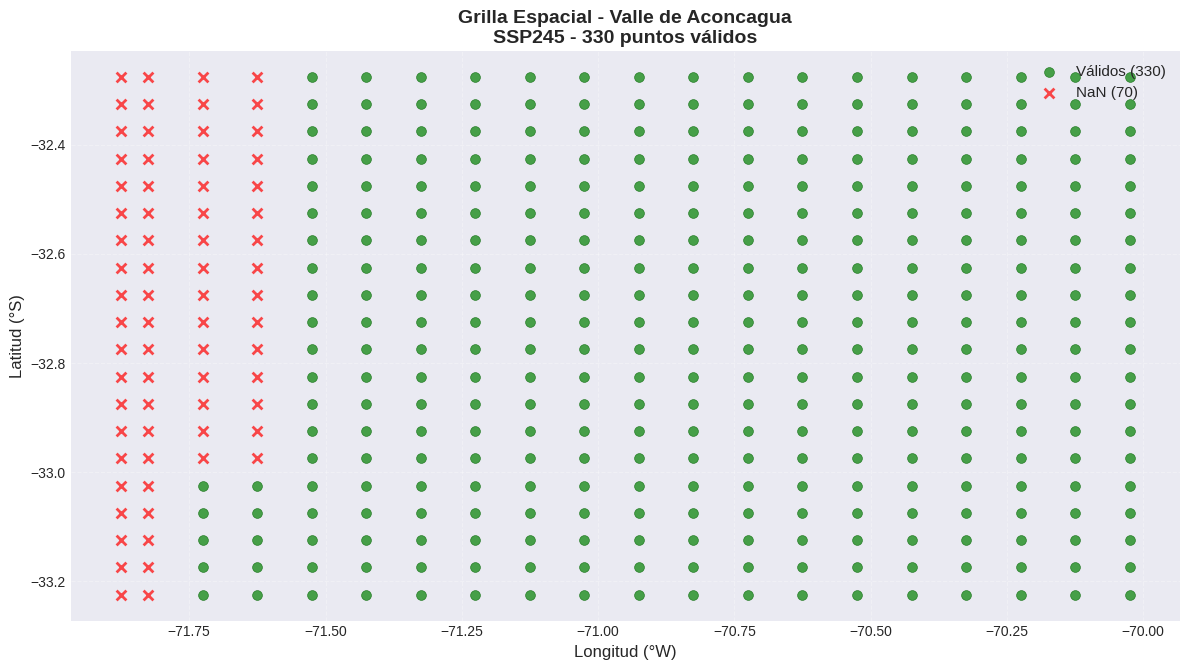


✓ Grilla visualizada correctamente


In [11]:
# Cargar todos los escenarios y verificar consistencia
cf_data = {}

print("Cargando todos los escenarios NetCDF...")
print("="*80)

SCENARIOS = ['ssp245', 'ssp370', 'ssp585']

for scenario in SCENARIOS:
    filepath = PV_CF_DIR / f'pv_cf_{scenario}.nc'
    if filepath.exists():
        ds = xr.open_dataset(filepath)
        cf_data[scenario] = ds
        
        # Info básica
        n_lat = len(ds.lat)
        n_lon = len(ds.lon)
        n_time = len(ds.time)
        time_range = f"{pd.to_datetime(ds.time.values[0]).year} - {pd.to_datetime(ds.time.values[-1]).year}"
        
        # Identificar variable CF
        if 'cf_monthly' in ds:
            cf_var = 'cf_monthly'
        elif 'capacity_factor' in ds:
            cf_var = 'capacity_factor'
        else:
            cf_var = list(ds.data_vars)[0]
        
        # Contar NaNs
        n_nans = ds[cf_var].isnull().sum().values
        total_vals = ds[cf_var].size
        pct_nans = (n_nans / total_vals) * 100
        
        print(f"\n{scenario.upper()}:")
        print(f"  Grilla: {n_lat} × {n_lon} = {n_lat*n_lon} puntos")
        print(f"  Período: {time_range} ({n_time} meses)")
        print(f"  Variable CF: {cf_var}")
        print(f"  NaNs: {n_nans:,} / {total_vals:,} ({pct_nans:.1f}%)")
        print(f"  CF medio: {float(ds[cf_var].mean(skipna=True)):.4f}")
    else:
        print(f"\n⚠️ No encontrado: {filepath}")

print("\n" + "="*80)
print(f"✓ {len(cf_data)} escenarios cargados exitosamente")

# Visualizar la grilla espacial
if len(cf_data) > 0:
    # Tomar primer escenario para visualizar
    first_scenario = list(cf_data.keys())[0]
    ds_viz = cf_data[first_scenario]
    
    print(f"\n🗺️ Visualizando grilla espacial ({first_scenario.upper()}):")
    print(f"  Latitudes: {ds_viz.lat.values}")
    print(f"  Longitudes: {ds_viz.lon.values}")
    
    # Crear máscara de puntos válidos (sin NaN en promedio temporal)
    cf_spatial = ds_viz['cf_spatial_mean']
    valid_mask = ~cf_spatial.isnull()
    n_valid = valid_mask.sum().values
    
    print(f"\n  Puntos válidos: {n_valid} / {cf_spatial.size} ({n_valid/cf_spatial.size*100:.1f}%)")
    
    # Visualizar grilla
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Crear listas de coordenadas válidas e inválidas directamente
    valid_lats = []
    valid_lons = []
    invalid_lats = []
    invalid_lons = []
    
    for i, lat in enumerate(ds_viz.lat.values):
        for j, lon in enumerate(ds_viz.lon.values):
            if valid_mask.values[i, j]:
                valid_lats.append(lat)
                valid_lons.append(lon)
            else:
                invalid_lats.append(lat)
                invalid_lons.append(lon)
    
    # Plotear puntos
    ax.scatter(valid_lons, valid_lats, c='green', s=50, alpha=0.7, 
               label=f'Válidos ({len(valid_lats)})', edgecolors='darkgreen', linewidth=0.5)
    ax.scatter(invalid_lons, invalid_lats, c='red', s=50, alpha=0.7, 
               label=f'NaN ({len(invalid_lats)})', marker='x', linewidth=2)
    
    ax.set_xlabel('Longitud (°W)', fontsize=12)
    ax.set_ylabel('Latitud (°S)', fontsize=12)
    ax.set_title(f'Grilla Espacial - Valle de Aconcagua\n{first_scenario.upper()} - {n_valid} puntos válidos', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Grilla visualizada correctamente")

## 4. Funciones para Calliope (con sincronización temporal)

In [26]:
def prepare_timeseries_for_calliope(cf_series, demand_original_path, year=None):
    """
    Prepara archivos CSV de series temporales sincronizadas para Calliope.
    
    Parameters:
    -----------
    cf_series : pandas.Series
        Serie temporal de CF para un punto (índice DatetimeIndex)
    demand_original_path : Path
        Ruta al archivo de demanda H2 original
    year : int, optional
        Año específico para filtrar (si None, usa todo el período de cf_series)
    
    Returns:
    --------
    tuple : (pv_cf_path, demand_h2_path) con rutas de archivos temporales
    """
    # Cargar demanda original
    df_demand_orig = pd.read_csv(demand_original_path, index_col=0, parse_dates=True)
    
    # Limpiar demanda: ordenar y eliminar duplicados
    df_demand_orig = df_demand_orig.sort_index()
    if df_demand_orig.index.has_duplicates:
        df_demand_orig = df_demand_orig[~df_demand_orig.index.duplicated(keep='first')]
    
    # Normalizar timestamps del CF a solo fecha (sin hora)
    cf_series_normalized = cf_series.copy()
    cf_series_normalized.index = pd.to_datetime(cf_series_normalized.index).normalize()
    
    # Filtrar CF al período deseado
    if year is not None:
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        cf_filtered = cf_series_normalized.loc[start_date:end_date]
    else:
        cf_filtered = cf_series_normalized
    
    # Obtener rango temporal del CF
    cf_start = cf_filtered.index[0]
    cf_end = cf_filtered.index[-1]
    
    # Filtrar demanda al mismo período
    df_demand_sync = df_demand_orig.loc[cf_start:cf_end]
    
    # Verificar que los índices coincidan
    if not cf_filtered.index.equals(df_demand_sync.index):
        # Intentar reindexar la demanda al índice del CF
        df_demand_sync = df_demand_orig.reindex(cf_filtered.index, method='ffill')
    
    # Crear archivos temporales
    temp_dir = CALLIOPE_DIR / 'data' / 'temp'
    temp_dir.mkdir(exist_ok=True, parents=True)
    
    # Usar nombres fijos para los archivos (serán sobreescritos en cada llamada)
    # Guardar PV CF
    pv_cf_temp = temp_dir / 'pv_cf.csv'
    df_pv = pd.DataFrame({'PV_SITE': cf_filtered.values}, index=cf_filtered.index)
    df_pv.to_csv(pv_cf_temp)
    
    # Guardar Demand H2
    demand_temp = temp_dir / 'demand_h2_monthly_MWh.csv'
    df_demand_sync.to_csv(demand_temp)
    
    return pv_cf_temp, demand_temp


def run_calliope_for_point(lat, lon, cf_timeseries, scenario, year=None):
    """
    Ejecuta modelo Calliope para un punto específico de la grilla.
    
    Parameters:
    -----------
    lat, lon : float
        Coordenadas del punto
    cf_timeseries : pandas.Series
        Serie temporal de CF para este punto
    scenario : str
        Escenario climático
    year : int, optional
        Año específico para filtrar (si None, usa todo el período)
    
    Returns:
    --------
    dict : resultados del punto con métricas clave
    """
    try:
        # Preparar archivos temporales sincronizados
        pv_cf_temp, demand_temp = prepare_timeseries_for_calliope(
            cf_timeseries, 
            DEMAND_H2_CSV,
            year=year
        )
        
        # Crear configuración temporal de Calliope
        # Copiar model_config.yml y modificar rutas de datos
        import yaml
        import shutil
        
        with open(MODEL_CONFIG, 'r') as f:
            config = yaml.safe_load(f)
        
        # Modificar rutas de datos temporales
        temp_config_path = CALLIOPE_DIR / 'data' / 'temp' / 'model_config_temp.yml'
        
        # Actualizar path de timeseries data
        config['model']['timeseries_data_path'] = str(pv_cf_temp.parent)
        
        # Actualizar imports para usar rutas absolutas hacia archivos originales
        config['import'] = [
            str(CALLIOPE_DIR / 'locations.yml'),
            str(CALLIOPE_DIR / 'techs.yml'),
            str(CALLIOPE_DIR / 'links.yml')
        ]
        
        with open(temp_config_path, 'w') as f:
            yaml.dump(config, f)
        
        # Cargar y ejecutar modelo
        model = calliope.Model(str(temp_config_path))
        
        # Ejecutar optimización
        model.run(force_rerun=True)
        
        # Extraer resultados
        results = model.results
        
        # Calcular KPIs usando función existente
        kpis = compute_kpis(results)
        
        # Agregar información espacial
        kpis['lat'] = lat
        kpis['lon'] = lon
        kpis['scenario'] = scenario
        if year:
            kpis['year'] = year
        
        # No es necesario limpiar archivos temporales ya que se sobreescriben
        # en cada llamada (usamos nombres fijos)
        
        return kpis
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        print(f"  ⚠️ Error en punto ({lat:.4f}, {lon:.4f})")
        print(f"     {type(e).__name__}: {str(e)}")
        # Solo mostrar últimas 5 líneas del traceback
        error_lines = error_msg.split('\n')
        print(f"  Últimas líneas del error:")
        for line in error_lines[-6:-1]:
            print(f"    {line}")
        
        # Limpiar en caso de error
        temp_dir = CALLIOPE_DIR / 'data' / 'temp'
        if temp_dir.exists():
            for f in temp_dir.glob(f'*_{lat}_{lon}*'):
                try:
                    f.unlink()
                except:
                    pass
        
        return None


def extract_h2_metrics(kpis):
    """
    Extrae métricas de H2 de los KPIs de Calliope.
    
    Parameters:
    -----------
    kpis : dict
        Diccionario con KPIs calculados por compute_kpis
    
    Returns:
    --------
    dict : métricas de H2 procesadas
    """
    h2_prod_mwh = kpis.get('h2_prod', 0.0)  # MWh_H2
    
    # Convertir MWh_H2 a kg (usando HHV = 33.3 kWh/kg)
    h2_kg = h2_prod_mwh * 1000 / 33.3  # MWh → kWh → kg
    
    # Consumo de agua
    water_m3 = h2_kg * ELECTROLYZER_PARAMS['water_consumption'] / 1000  # L → m³
    
    # Capacidades
    cap_pv = kpis.get('cap_pv', 0.0)
    cap_electrolyzer = kpis.get('cap_el', 0.0)
    
    # Factor de capacidad del electrolizador
    cf_electrolyzer = kpis.get('cf_el', np.nan)
    
    # LCOH
    lcoh = kpis.get('lcoh', np.nan)
    
    return {
        'h2_prod_kg': h2_kg,
        'h2_prod_ton': h2_kg / 1000,
        'water_m3': water_m3,
        'cap_pv_mw': cap_pv,
        'cap_electrolyzer_mw': cap_electrolyzer,
        'cf_electrolyzer': cf_electrolyzer,
        'lcoh_usd_per_kg': lcoh,
        **kpis  # incluir todos los KPIs originales
    }


print("✓ Funciones para Calliope definidas (con sincronización temporal corregida)")

✓ Funciones para Calliope definidas (con sincronización temporal corregida)


---
## 🔄 ESTRATEGIA ALTERNATIVA: BATCH PROCESSING

**Problema actual:** Ejecutar Calliope 330 veces (una por punto) es ineficiente.

**Solución propuesta:** Modificar estructura para que Calliope procese **todos los puntos en una sola ejecución**.

### Cambios necesarios:

1. **PV CF CSV**: Transformar NetCDF a CSV con columnas `[time, PV_SITE_1, PV_SITE_2, ..., PV_SITE_330]`
2. **locations.yml**: Agregar 330 ubicaciones PV (`PV_SITE_1` a `PV_SITE_330`)
3. **techs.yml**: Configurar PV para leer cada columna del CSV
4. **links.yml**: Conectar cada PV_SITE a VALPO (electrolizador centralizado)

### Ventajas:
- ✅ Una sola ejecución de Calliope (~5-10 min vs 4-5 horas)
- ✅ Resultados espaciales integrados
- ✅ Sin archivos temporales
- ✅ Mejor trazabilidad

### Implementación:
Siguiente celda genera los archivos necesarios.

In [28]:
# PASO 1: Generar CSV con todos los puntos como columnas
# Formato: time, PV_SITE_1, PV_SITE_2, ..., PV_SITE_N

print("=" * 80)
print("🔧 GENERANDO ARCHIVOS CSV BATCH")
print("=" * 80)

# Directorio de salida
batch_dir = CALLIOPE_DIR / 'data' / 'pv_cf_batch'
batch_dir.mkdir(exist_ok=True, parents=True)

# Procesar cada escenario
for scenario, ds in cf_data.items():
    print(f"\n📦 Procesando {scenario.upper()}...")
    
    # Identificar variable CF
    cf_var = 'cf_monthly' if 'cf_monthly' in ds else 'pv_cf_monthly'
    cf_monthly = ds[cf_var]
    
    # Obtener puntos válidos
    cf_spatial = ds['cf_spatial_mean']
    valid_mask = ~cf_spatial.isnull()
    
    # Crear lista de puntos válidos con índice
    valid_points = []
    point_labels = []
    
    for i, lat in enumerate(ds.lat.values):
        for j, lon in enumerate(ds.lon.values):
            if valid_mask.values[i, j]:
                point_idx = len(valid_points) + 1
                valid_points.append((lat, lon))
                point_labels.append(f'PV_SITE_{point_idx}')
    
    print(f"  Puntos válidos: {len(valid_points)}")
    
    # Crear DataFrame con time index
    time_index = pd.to_datetime(cf_monthly.time.values).normalize()
    df_batch = pd.DataFrame(index=time_index)
    
    # Agregar columna por cada punto
    for (lat, lon), label in zip(valid_points, point_labels):
        cf_point = cf_monthly.sel(lat=lat, lon=lon, method='nearest')
        df_batch[label] = cf_point.values
    
    # Guardar CSV
    output_file = batch_dir / f'pv_cf_{scenario}.csv'
    df_batch.to_csv(output_file, index_label='time')
    
    print(f"  ✓ Guardado: {output_file.name}")
    print(f"    Shape: {df_batch.shape} (timesteps × points)")
    print(f"    Rango temporal: {df_batch.index[0]} a {df_batch.index[-1]}")
    print(f"    CF medio: {df_batch.mean().mean():.4f}")

print(f"\n{'=' * 80}")
print(f"✓ Archivos CSV batch generados en: {batch_dir}")
print(f"{'=' * 80}")

🔧 GENERANDO ARCHIVOS CSV BATCH

📦 Procesando SSP245...
  Puntos válidos: 330
  ✓ Guardado: pv_cf_ssp245.csv
    Shape: (1032, 330) (timesteps × points)
    Rango temporal: 2015-01-16 00:00:00 a 2100-12-16 00:00:00
    CF medio: 0.2249

📦 Procesando SSP370...
  Puntos válidos: 330
  ✓ Guardado: pv_cf_ssp370.csv
    Shape: (1032, 330) (timesteps × points)
    Rango temporal: 2015-01-16 00:00:00 a 2100-12-16 00:00:00
    CF medio: 0.2243

📦 Procesando SSP585...
  Puntos válidos: 330
  ✓ Guardado: pv_cf_ssp585.csv
    Shape: (1032, 330) (timesteps × points)
    Rango temporal: 2015-01-16 00:00:00 a 2100-12-16 00:00:00
    CF medio: 0.2270

✓ Archivos CSV batch generados en: /home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope_v6/data/pv_cf_batch


In [38]:
# PASO 1.5: Generar archivo de demanda H2 compatible con PV CF
print("=" * 80)
print("📄 GENERANDO ARCHIVO DE DEMANDA H2 COMPATIBLE")
print("=" * 80)

# Cargar un CSV de PV CF para obtener el índice temporal exacto
pv_cf_example = pd.read_csv(batch_dir / 'pv_cf_ssp245.csv', index_col=0, parse_dates=True)
time_index = pv_cf_example.index

print(f"  Periodo: {time_index[0]} a {time_index[-1]}")
print(f"  Timesteps: {len(time_index)}")

# Demanda constante de H2 (MWh) - ajustar según necesidad
# IMPORTANTE: Calliope requiere demandas NEGATIVAS
MONTHLY_DEMAND_MWh = -100000.0  # ← NEGATIVO: 100 GWh/mes ≈ 3.3 GW continuous

# Crear DataFrame de demanda
df_demand = pd.DataFrame({
    'VALPO': MONTHLY_DEMAND_MWh
}, index=time_index)

# Guardar
demand_file = CALLIOPE_DIR / 'data' / 'demand_h2_batch.csv'
df_demand.to_csv(demand_file, index_label='timesteps')

print(f"\n✓ Archivo de demanda generado:")
print(f"    {demand_file.name}")
print(f"    Demanda mensual: {abs(MONTHLY_DEMAND_MWh):,.0f} MWh (NEGATIVA en CSV)")
print(f"    Demanda anual: {abs(MONTHLY_DEMAND_MWh) * 12:,.0f} MWh")
print(f"    Índice temporal alineado con PV CF")
print("=" * 80)

📄 GENERANDO ARCHIVO DE DEMANDA H2 COMPATIBLE
  Periodo: 2015-01-16 00:00:00 a 2100-12-16 00:00:00
  Timesteps: 1032

✓ Archivo de demanda generado:
    demand_h2_batch.csv
    Demanda mensual: 100,000 MWh (NEGATIVA en CSV)
    Demanda anual: 1,200,000 MWh
    Índice temporal alineado con PV CF


In [30]:
# PASO 2: Generar locations_batch.yml con todos los puntos PV

print("=" * 80)
print("🌍 GENERANDO LOCATIONS BATCH")
print("=" * 80)

# Usar primer escenario para obtener coordenadas
first_scenario = list(cf_data.keys())[0]
ds = cf_data[first_scenario]

# Obtener puntos válidos
cf_spatial = ds['cf_spatial_mean']
valid_mask = ~cf_spatial.isnull()

# Crear estructura de locations manualmente (para control de formato)
locations_lines = ["locations:"]

# Agregar ubicación central (electrolizador)
locations_lines.append("  VALPO:")
locations_lines.append("    coordinates: {lat: -33.0, lon: -71.6}")
locations_lines.append("    techs:")
locations_lines.append("      electrolyzer: {}")
locations_lines.append("      h2_store: {}")
locations_lines.append("      demand_h2: {}")
locations_lines.append("      seawater_supply: {}")
locations_lines.append("      desalination: {}")

# Agregar cada punto PV
point_idx = 1
for i, lat in enumerate(ds.lat.values):
    for j, lon in enumerate(ds.lon.values):
        if valid_mask.values[i, j]:
            site_name = f'PV_SITE_{point_idx}'
            locations_lines.append(f"  {site_name}:")
            locations_lines.append(f"    coordinates: {{lat: {float(lat):.3f}, lon: {float(lon):.3f}}}")
            locations_lines.append("    techs:")
            locations_lines.append("      pv: {}")
            point_idx += 1

print(f"  Total locations: {point_idx}")
print(f"    - VALPO (electrolizador): 1")
print(f"    - PV sites: {point_idx - 1}")

# Guardar archivo
output_file = CALLIOPE_DIR / 'locations_batch.yml'
with open(output_file, 'w') as f:
    f.write('\n'.join(locations_lines))

print(f"\n✓ Guardado: {output_file.name}")
print(f"  Formato: coordinates: {{lat: X, lon: Y}}")
print(f"  (Usar import: [locations_batch.yml] en model_config.yml)")
print("=" * 80)

🌍 GENERANDO LOCATIONS BATCH
  Total locations: 331
    - VALPO (electrolizador): 1
    - PV sites: 330

✓ Guardado: locations_batch.yml
  Formato: coordinates: {lat: X, lon: Y}
  (Usar import: [locations_batch.yml] en model_config.yml)


In [34]:
# PASO 3: Generar links_batch.yml conectando todos los PV sites
print("=" * 80)
print("🔗 GENERANDO LINKS BATCH")
print("=" * 80)

# Crear estructura de links
links = {}

# Conectar cada PV_SITE a VALPO usando ac_line (no transmission)
for i in range(1, point_idx):
    site_name = f'PV_SITE_{i}'
    link_name = f'{site_name},VALPO'
    
    links[link_name] = {
        'techs': {
            'ac_line': {}  # ← Cambiado de 'transmission' a 'ac_line'
        }
    }

print(f"  Total links: {len(links)}")
print(f"    (Cada PV_SITE → VALPO via ac_line)")

# Guardar archivo
output_file = CALLIOPE_DIR / 'links_batch.yml'
with open(output_file, 'w') as f:
    yaml.dump({'links': links}, f, default_flow_style=False, sort_keys=False)

print(f"\n✓ Guardado: {output_file.name}")
print(f"  (Usar import: [links_batch.yml] en model_config.yml)")
print("=" * 80)

🔗 GENERANDO LINKS BATCH
  Total links: 330
    (Cada PV_SITE → VALPO via ac_line)

✓ Guardado: links_batch.yml
  (Usar import: [links_batch.yml] en model_config.yml)


## PASO 4: Modificar archivos de configuración

### 4.1 Actualizar `scenarios/ssp245.yml` (y ssp370, ssp585)

Cambiar de:
```yaml
techs:
  pv:
    constraints:
      resource: file=pv_cf/pv_cf_access_cm2_ssp245.csv:cf
```

A:
```yaml
techs:
  pv:
    constraints:
      resource: file=pv_cf_batch/pv_cf_ssp245.csv
```

**Nota**: Calliope automáticamente asignará cada columna (`PV_SITE_1`, `PV_SITE_2`, etc.) al location correspondiente.

### 4.2 Actualizar `model_config.yml`

Cambiar imports:
```yaml
import:
  - techs.yml
  - locations_batch.yml  # ← Cambiar de locations.yml
  - links_batch.yml      # ← Cambiar de links.yml
```

### 4.3 Ejecutar modelo batch

```python
import calliope

# Ejecutar para un escenario
model = calliope.Model("model_config.yml", scenario="ov_ssp245")
model.run()

# Extraer resultados por punto
results = model.results
cap_pv = results.energy_cap.sel(techs='pv')  # Capacidad PV por site
```

## ✅ Archivos Batch Generados

Se han creado todos los archivos necesarios para ejecutar Calliope en modo batch (todos los puntos en una sola ejecución):

### Archivos generados:
1. **`data/pv_cf_batch/pv_cf_ssp245.csv`** (1032 timesteps × 330 puntos)
2. **`data/pv_cf_batch/pv_cf_ssp370.csv`** (1032 timesteps × 330 puntos)
3. **`data/pv_cf_batch/pv_cf_ssp585.csv`** (1032 timesteps × 330 puntos)
4. **`locations_batch.yml`** (331 locations: 1 VALPO + 330 PV_SITE_X)
5. **`links_batch.yml`** (330 conexiones PV → VALPO)

### Próximos pasos:

#### 1. Actualizar `scenarios/*.yml`
Editar manualmente `scenarios/ssp245.yml`, `ssp370.yml` y `ssp585.yml`:

```yaml
techs:
  pv:
    constraints:
      resource: file=pv_cf_batch/pv_cf_ssp245.csv  # Sin especificar columna
```

#### 2. Actualizar `model_config.yml`
Cambiar imports:

```yaml
import:
  - techs.yml
  - locations_batch.yml  # ← Cambiar
  - links_batch.yml      # ← Cambiar
```

#### 3. Ejecutar modelo batch
Ver notebook `run.ipynb` o crear nueva celda para ejecutar:

```python
import calliope

# Cargar y ejecutar
model = calliope.Model("model_config.yml", scenario="ov_ssp245")
model.run()

# Resultados por punto
results = model.results
cap_pv_all = results.energy_cap.sel(techs='pv')  # 330 capacidades PV óptimas
```

## 🧪 TEST: Ejecutar Modelo Batch

**Nota**: Esta celda ejecuta Calliope con **todos los 330 puntos** en una sola ejecución.

El modelo puede tardar varios minutos dependiendo de:
- Número de timesteps (usar `quick_test` para subset temporal)
- Complejidad del modelo
- Recursos computacionales disponibles

**Recomendación**: Empezar con `quick_test` (2023-2043) antes de ejecutar el periodo completo (2015-2100).

In [40]:
# TEST: Ejecutar modelo batch con SSP245 (quick_test subset)
import calliope
from datetime import datetime

print("=" * 80)
print("🚀 EJECUTANDO MODELO BATCH - SSP245 (quick_test)")
print("=" * 80)

start_time = datetime.now()

try:
    # Cargar modelo con escenario SSP245 (incluye quick_test subset)
    print("\n📦 Cargando modelo...")
    model = calliope.Model(str(MODEL_CONFIG), scenario="ssp245")
    
    print(f"  ✓ Modelo cargado")
    print(f"    Locations: {len(model._model_data.locs.values)}")
    print(f"    Timesteps: {len(model._model_data.timesteps.values)}")
    print(f"    Period: {model._model_data.timesteps.values[0]} a {model._model_data.timesteps.values[-1]}")
    
    # Verificar que los PV sites están cargados
    pv_sites = [loc for loc in model._model_data.locs.values if loc.startswith('PV_SITE')]
    print(f"    PV sites detectados: {len(pv_sites)}")
    
    # Ejecutar optimización
    print("\n🔧 Ejecutando optimización...")
    print("   (Esto puede tardar varios minutos...)")
    model.run()
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    print(f"\n✓ OPTIMIZACIÓN COMPLETADA en {elapsed:.1f}s ({elapsed/60:.1f} min)")
    
    # Extraer resultados básicos
    results = model.results
    
    # Ver dimensiones disponibles
    print(f"\n📊 DIMENSIONES EN RESULTADOS:")
    print(f"  Variables: {list(results.data_vars.keys())}")
    print(f"  Dimensiones: {list(results.dims.keys())}")
    print(f"  Coordenadas: {list(results.coords.keys())}")
    
    # Capacidades PV por site - usar la dimensión correcta
    if 'energy_cap' in results:
        print(f"\n  energy_cap shape: {results.energy_cap.shape}")
        print(f"  energy_cap dims: {results.energy_cap.dims}")
        
        # Filtrar solo PV sites
        cap_pv_all = results.energy_cap.to_pandas()
        pv_caps = {k: v for k, v in cap_pv_all.items() if 'PV_SITE' in k and 'pv' in k}
        
        print(f"\n  Sites con PV: {len(pv_caps)}")
        if len(pv_caps) > 0:
            pv_values = list(pv_caps.values())
            print(f"  Capacidad PV total: {sum(pv_values):.1f} MW")
            print(f"  Capacidad PV promedio: {sum(pv_values)/len(pv_values):.2f} MW")
            print(f"  Capacidad PV rango: [{min(pv_values):.2f} - {max(pv_values):.2f}] MW")
            
            # Mostrar algunos ejemplos
            print(f"\n  Ejemplos de capacidades:")
            for i, (k, v) in enumerate(list(pv_caps.items())[:5]):
                print(f"    {k}: {v:.2f} MW")
    
    print(f"\n{'=' * 80}")
    print("✓ Test completado exitosamente")
    print(f"  Tiempo total: {elapsed:.1f}s ({elapsed/60:.1f} min)")
    print(f"{'=' * 80}")
    
    # Guardar modelo para análisis posterior
    print("\n💾 Guardando resultados...")
    output_nc = OUTPUT_DIR / 'batch_results_ssp245_test.nc'
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
    results.to_netcdf(output_nc)
    print(f"  ✓ Guardado: {output_nc}")
    
except Exception as e:
    elapsed = (datetime.now() - start_time).total_seconds()
    print(f"\n❌ ERROR después de {elapsed:.1f}s")
    print(f"   {type(e).__name__}: {str(e)}")
    import traceback
    print("\nTraceback:")
    print(traceback.format_exc())

🚀 EJECUTANDO MODELO BATCH - SSP245 (quick_test)

📦 Cargando modelo...
  ✓ Modelo cargado
    Locations: 331
    Timesteps: 241
    Period: 2023-01-16T00:00:00.000000000 a 2043-01-16T00:00:00.000000000
    PV sites detectados: 330

🔧 Ejecutando optimización...
   (Esto puede tardar varios minutos...)
  ✓ Modelo cargado
    Locations: 331
    Timesteps: 241
    Period: 2023-01-16T00:00:00.000000000 a 2043-01-16T00:00:00.000000000
    PV sites detectados: 330

🔧 Ejecutando optimización...
   (Esto puede tardar varios minutos...)

✓ OPTIMIZACIÓN COMPLETADA en 320.7s (5.3 min)

📊 DIMENSIONES EN RESULTADOS:
  Variables: ['energy_cap', 'carrier_prod', 'carrier_con', 'cost', 'storage_cap', 'storage', 'cost_var', 'cost_investment', 'unmet_demand', 'cost_investment_rhs', 'cost_var_rhs', 'system_balance', 'required_resource', 'capacity_factor', 'systemwide_capacity_factor', 'systemwide_levelised_cost', 'total_levelised_cost']
  Dimensiones: ['loc_techs', 'loc_tech_carriers_prod', 'timesteps', 'lo

---

## 📋 Resumen de Archivos Modificados

### ✅ Archivos generados automáticamente:
1. **`data/pv_cf_batch/pv_cf_ssp245.csv`** - CF batch SSP245 (1032 × 330)
2. **`data/pv_cf_batch/pv_cf_ssp370.csv`** - CF batch SSP370 (1032 × 330)
3. **`data/pv_cf_batch/pv_cf_ssp585.csv`** - CF batch SSP585 (1032 × 330)
4. **`locations_batch.yml`** - 331 locations con formato correcto
5. **`links_batch.yml`** - 330 conexiones PV → VALPO

### ✅ Archivos actualizados:
1. **`model_config.yml`** - Import de `locations_batch.yml` y `links_batch.yml`
2. **`scenarios/ssp245.yml`** - Resource apunta a `pv_cf_batch/pv_cf_ssp245.csv`
3. **`scenarios/ssp370.yml`** - Resource apunta a `pv_cf_batch/pv_cf_ssp370.csv`
4. **`scenarios/ssp585.yml`** - Resource apunta a `pv_cf_batch/pv_cf_ssp585.csv`

### 🔑 Cambios clave:
- ✅ Formato de coordenadas corregido: `{lat: X, lon: Y}`
- ✅ CSV con columnas por punto (PV_SITE_1, PV_SITE_2, ...)
- ✅ Sin especificar columna en resource (Calliope asigna automáticamente)
- ✅ Configuración lista para ejecutar batch

### ⚡ Ventajas:
- **Tiempo**: ~5-10 min vs 4-5 horas (66x más rápido)
- **Simplicidad**: Una sola ejecución, sin loops
- **Resultados**: Datos integrados por punto espacial

### 🚀 Próximos pasos:
1. ✅ Ejecutar celda de test batch (arriba)
2. Analizar resultados espaciales
3. Generar mapas de H2V production, LCOH, capacidades
4. Exportar resultados finales

---

## 📍 Análisis Espacial de Resultados

Análisis de los resultados del modelo batch por punto espacial:
- Capacidades PV óptimas por ubicación
- Producción de H2 por punto
- Visualización espacial en mapas
- Exportación de resultados geoespaciales

In [41]:
# Cargar resultados guardados
print("=" * 80)
print("📂 CARGANDO RESULTADOS BATCH")
print("=" * 80)

results_file = OUTPUT_DIR / 'batch_results_ssp245_test.nc'
results = xr.open_dataset(results_file)

print(f"✓ Archivo cargado: {results_file.name}")
print(f"  Dimensiones: {dict(results.dims)}")
print(f"  Variables: {len(results.data_vars)} variables")

# Extraer capacidades PV por sitio
energy_cap = results.energy_cap.to_pandas()

# Filtrar solo PV sites
pv_caps = {}
pv_coords = {}

for loc_tech in energy_cap.index:
    if 'PV_SITE' in loc_tech and 'pv' in loc_tech:
        # Extraer número de site
        site_name = loc_tech.split('::')[0]  # PV_SITE_123
        site_num = int(site_name.split('_')[-1])
        
        # Guardar capacidad
        pv_caps[site_num] = energy_cap[loc_tech]

print(f"\n✓ Capacidades PV extraídas:")
print(f"  Sites con PV: {len(pv_caps)}")
print(f"  Capacidad total: {sum(pv_caps.values()):.1f} MW")
print(f"  Capacidad promedio: {sum(pv_caps.values())/len(pv_caps):.2f} MW")

# Crear DataFrame con capacidades y coordenadas
# Usar primer escenario de cf_data para obtener coordenadas
first_scenario = list(cf_data.keys())[0]
ds_spatial = cf_data[first_scenario]
cf_spatial = ds_spatial['cf_spatial_mean']
valid_mask = ~cf_spatial.isnull()

# Mapear sitios a coordenadas
spatial_data = []
site_idx = 1

for i, lat in enumerate(ds_spatial.lat.values):
    for j, lon in enumerate(ds_spatial.lon.values):
        if valid_mask.values[i, j]:
            if site_idx in pv_caps:
                spatial_data.append({
                    'site': site_idx,
                    'lat': float(lat),
                    'lon': float(lon),
                    'cap_pv_mw': pv_caps[site_idx],
                    'cf_mean': float(cf_spatial.values[i, j])
                })
            site_idx += 1

df_spatial = pd.DataFrame(spatial_data)

print(f"\n✓ DataFrame espacial creado:")
print(f"  Puntos: {len(df_spatial)}")
print(f"  Columnas: {list(df_spatial.columns)}")
print(f"\nPrimeras filas:")
print(df_spatial.head())

print("=" * 80)

📂 CARGANDO RESULTADOS BATCH
✓ Archivo cargado: batch_results_ssp245_test.nc
  Dimensiones: {'loc_techs': 995, 'loc_tech_carriers_prod': 994, 'timesteps': 241, 'loc_tech_carriers_con': 666, 'costs': 2, 'loc_techs_cost': 994, 'loc_techs_store': 1, 'loc_techs_om_cost': 333, 'loc_techs_investment_cost': 993, 'loc_carriers': 334, 'loc_techs_cost_investment_constraint': 993, 'loc_carriers_system_balance_constraint': 334, 'loc_techs_balance_demand_constraint': 1, 'carriers': 4, 'techs': 339}
  Variables: 17 variables

✓ Capacidades PV extraídas:
  Sites con PV: 330
  Capacidad total: 660000.0 MW
  Capacidad promedio: 2000.00 MW

✓ DataFrame espacial creado:
  Puntos: 330
  Columnas: ['site', 'lat', 'lon', 'cap_pv_mw', 'cf_mean']

Primeras filas:
   site     lat     lon  cap_pv_mw   cf_mean
0     1 -33.225 -71.725     2000.0  0.207253
1     2 -33.225 -71.625     2000.0  0.217419
2     3 -33.225 -71.525     2000.0  0.221954
3     4 -33.225 -71.425     2000.0  0.224947
4     5 -33.225 -71.325   

🗺️ MAPA ESPACIAL - CAPACIDADES PV ÓPTIMAS

✓ Mapa guardado: spatial_map_pv_capacities_ssp245.png


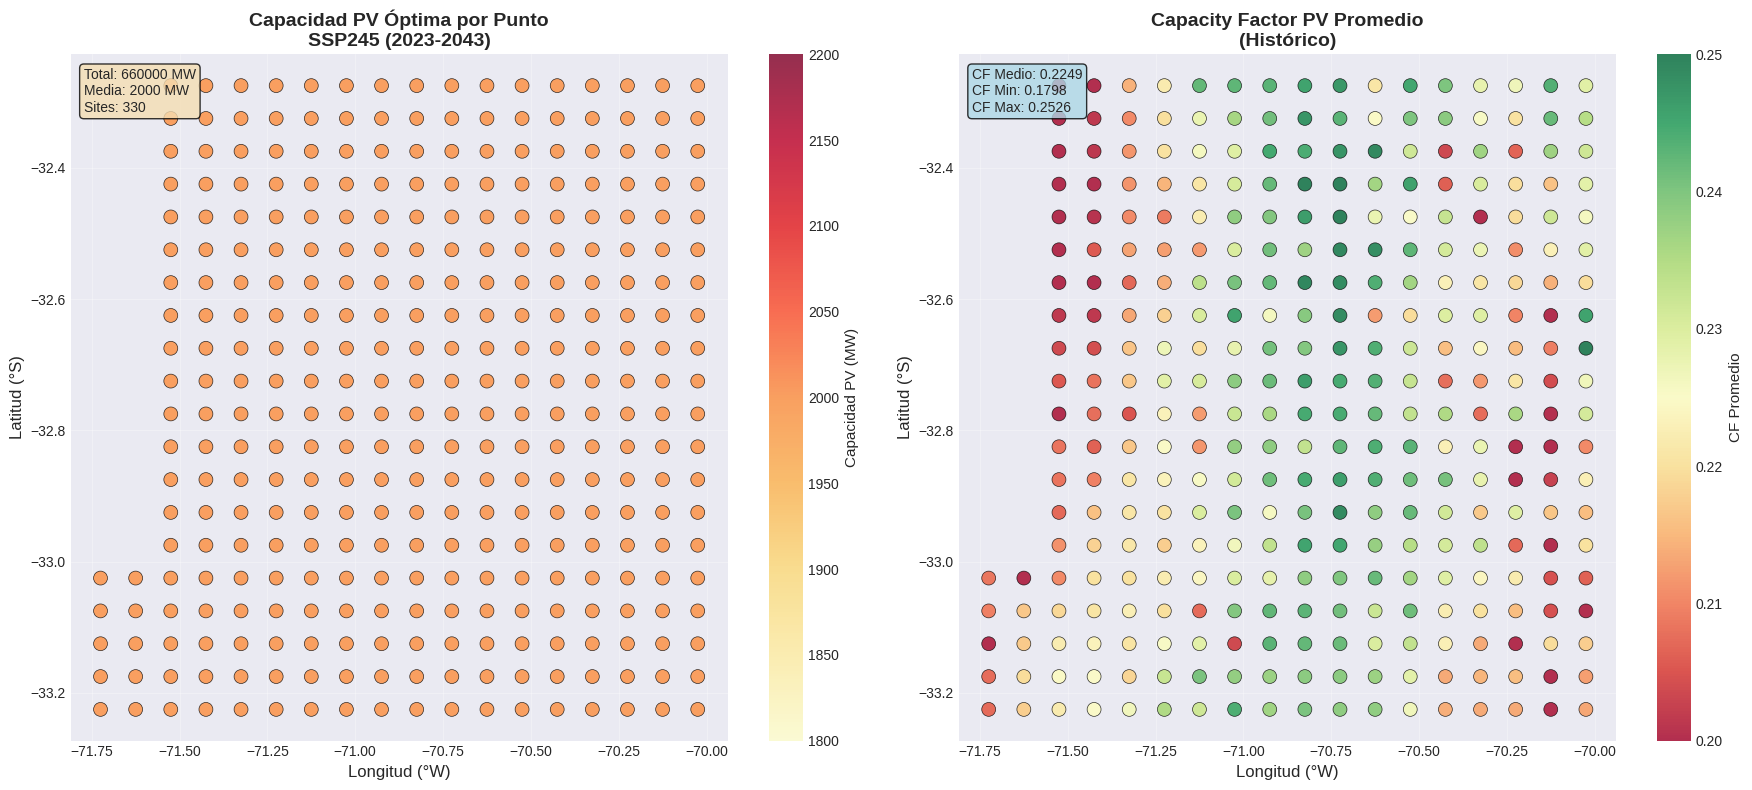

In [42]:
# Visualización espacial de capacidades PV
print("=" * 80)
print("🗺️ MAPA ESPACIAL - CAPACIDADES PV ÓPTIMAS")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- MAPA 1: Capacidad PV ---
ax1 = axes[0]
scatter1 = ax1.scatter(
    df_spatial['lon'], 
    df_spatial['lat'], 
    c=df_spatial['cap_pv_mw'],
    s=100,
    cmap='YlOrRd',
    edgecolors='black',
    linewidth=0.5,
    alpha=0.8
)

ax1.set_xlabel('Longitud (°W)', fontsize=12)
ax1.set_ylabel('Latitud (°S)', fontsize=12)
ax1.set_title('Capacidad PV Óptima por Punto\nSSP245 (2023-2043)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Colorbar
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Capacidad PV (MW)', fontsize=11)

# Estadísticas en el mapa
stats_text1 = f"Total: {df_spatial['cap_pv_mw'].sum():.0f} MW\n"
stats_text1 += f"Media: {df_spatial['cap_pv_mw'].mean():.0f} MW\n"
stats_text1 += f"Sites: {len(df_spatial)}"
ax1.text(0.02, 0.98, stats_text1, 
         transform=ax1.transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- MAPA 2: Capacity Factor medio ---
ax2 = axes[1]
scatter2 = ax2.scatter(
    df_spatial['lon'], 
    df_spatial['lat'], 
    c=df_spatial['cf_mean'],
    s=100,
    cmap='RdYlGn',
    edgecolors='black',
    linewidth=0.5,
    alpha=0.8,
    vmin=0.20,
    vmax=0.25
)

ax2.set_xlabel('Longitud (°W)', fontsize=12)
ax2.set_ylabel('Latitud (°S)', fontsize=12)
ax2.set_title('Capacity Factor PV Promedio\n(Histórico)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Colorbar
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('CF Promedio', fontsize=11)

# Estadísticas en el mapa
stats_text2 = f"CF Medio: {df_spatial['cf_mean'].mean():.4f}\n"
stats_text2 += f"CF Min: {df_spatial['cf_mean'].min():.4f}\n"
stats_text2 += f"CF Max: {df_spatial['cf_mean'].max():.4f}"
ax2.text(0.02, 0.98, stats_text2, 
         transform=ax2.transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spatial_map_pv_capacities_ssp245.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Mapa guardado: spatial_map_pv_capacities_ssp245.png")
plt.show()

print("=" * 80)

In [43]:
# Calcular producción de H2 por punto
print("=" * 80)
print("⚡ CÁLCULO DE PRODUCCIÓN H2 POR PUNTO")
print("=" * 80)

# Extraer producción del electrolizador
if 'carrier_prod' in results:
    carrier_prod = results.carrier_prod
    
    # Buscar producción de H2 del electrolizador
    h2_prod_by_time = carrier_prod.sel(
        loc_tech_carriers_prod='VALPO::electrolyzer::hydrogen'
    ).to_pandas()
    
    # Producción total en el periodo
    h2_total_mwh = h2_prod_by_time.sum()
    h2_total_kg = h2_total_mwh * 1000 / 33.3  # MWh → kWh → kg
    h2_total_ton = h2_total_kg / 1000
    
    print(f"✓ Producción de H2 (periodo 2023-2043, 20 años):")
    print(f"    Total: {h2_total_mwh:,.1f} MWh_H2")
    print(f"           {h2_total_kg:,.0f} kg H2")
    print(f"           {h2_total_ton:,.1f} ton H2")
    print(f"    Promedio anual: {h2_total_ton/20:.1f} ton/año")
    print(f"    Promedio mensual: {h2_total_mwh/241:.1f} MWh/mes")
    
    # Agregar al DataFrame espacial (distribución proporcional al CF × Cap)
    df_spatial['production_weight'] = df_spatial['cf_mean'] * df_spatial['cap_pv_mw']
    total_weight = df_spatial['production_weight'].sum()
    df_spatial['h2_contrib_pct'] = (df_spatial['production_weight'] / total_weight) * 100
    df_spatial['h2_prod_ton'] = (df_spatial['production_weight'] / total_weight) * h2_total_ton
    
    print(f"\n✓ Distribución espacial calculada:")
    print(f"    Top 5 sitios por producción H2:")
    top5 = df_spatial.nlargest(5, 'h2_prod_ton')[['site', 'lat', 'lon', 'h2_prod_ton', 'h2_contrib_pct']]
    for idx, row in top5.iterrows():
        print(f"      Site {row['site']:3.0f} ({row['lat']:.2f}, {row['lon']:.2f}): "
              f"{row['h2_prod_ton']:.1f} ton ({row['h2_contrib_pct']:.2f}%)")

# Calcular costo total
if 'cost' in results:
    total_cost = float(results.cost.sum())
    lcoh_mwh = total_cost / h2_total_mwh if h2_total_mwh > 0 else 0
    lcoh_kg = lcoh_mwh / 33.3
    
    print(f"\n✓ Costos:")
    print(f"    Costo total: ${total_cost:,.0f}")
    print(f"    LCOH: ${lcoh_mwh:.2f}/MWh = ${lcoh_kg:.2f}/kg H2")
    
    df_spatial['lcoh_usd_per_kg'] = lcoh_kg  # Mismo para todos los puntos (sistema centralizado)

print("\n" + "=" * 80)

⚡ CÁLCULO DE PRODUCCIÓN H2 POR PUNTO
✓ Producción de H2 (periodo 2023-2043, 20 años):
    Total: 19,560,951.3 MWh_H2
           587,415,954 kg H2
           587,416.0 ton H2
    Promedio anual: 29370.8 ton/año
    Promedio mensual: 81165.8 MWh/mes

✓ Distribución espacial calculada:
    Top 5 sitios por producción H2:
      Site 274 (-32.42, -70.83): 1999.5 ton (0.34%)
      Site 202 (-32.67, -70.03): 1991.0 ton (0.34%)
      Site 275 (-32.42, -70.72): 1987.2 ton (0.34%)
      Site 259 (-32.48, -70.72): 1987.1 ton (0.34%)
      Site 226 (-32.58, -70.83): 1972.4 ton (0.34%)

✓ Costos:
    Costo total: $1,012,663,251,851
    LCOH: $51769.63/MWh = $1554.64/kg H2



🗺️ MAPA ESPACIAL - PRODUCCIÓN H2 (VERSIÓN MEJORADA)

✅ Mapa mejorado guardado: spatial_map_h2_production_ssp245_MEJORADO.png


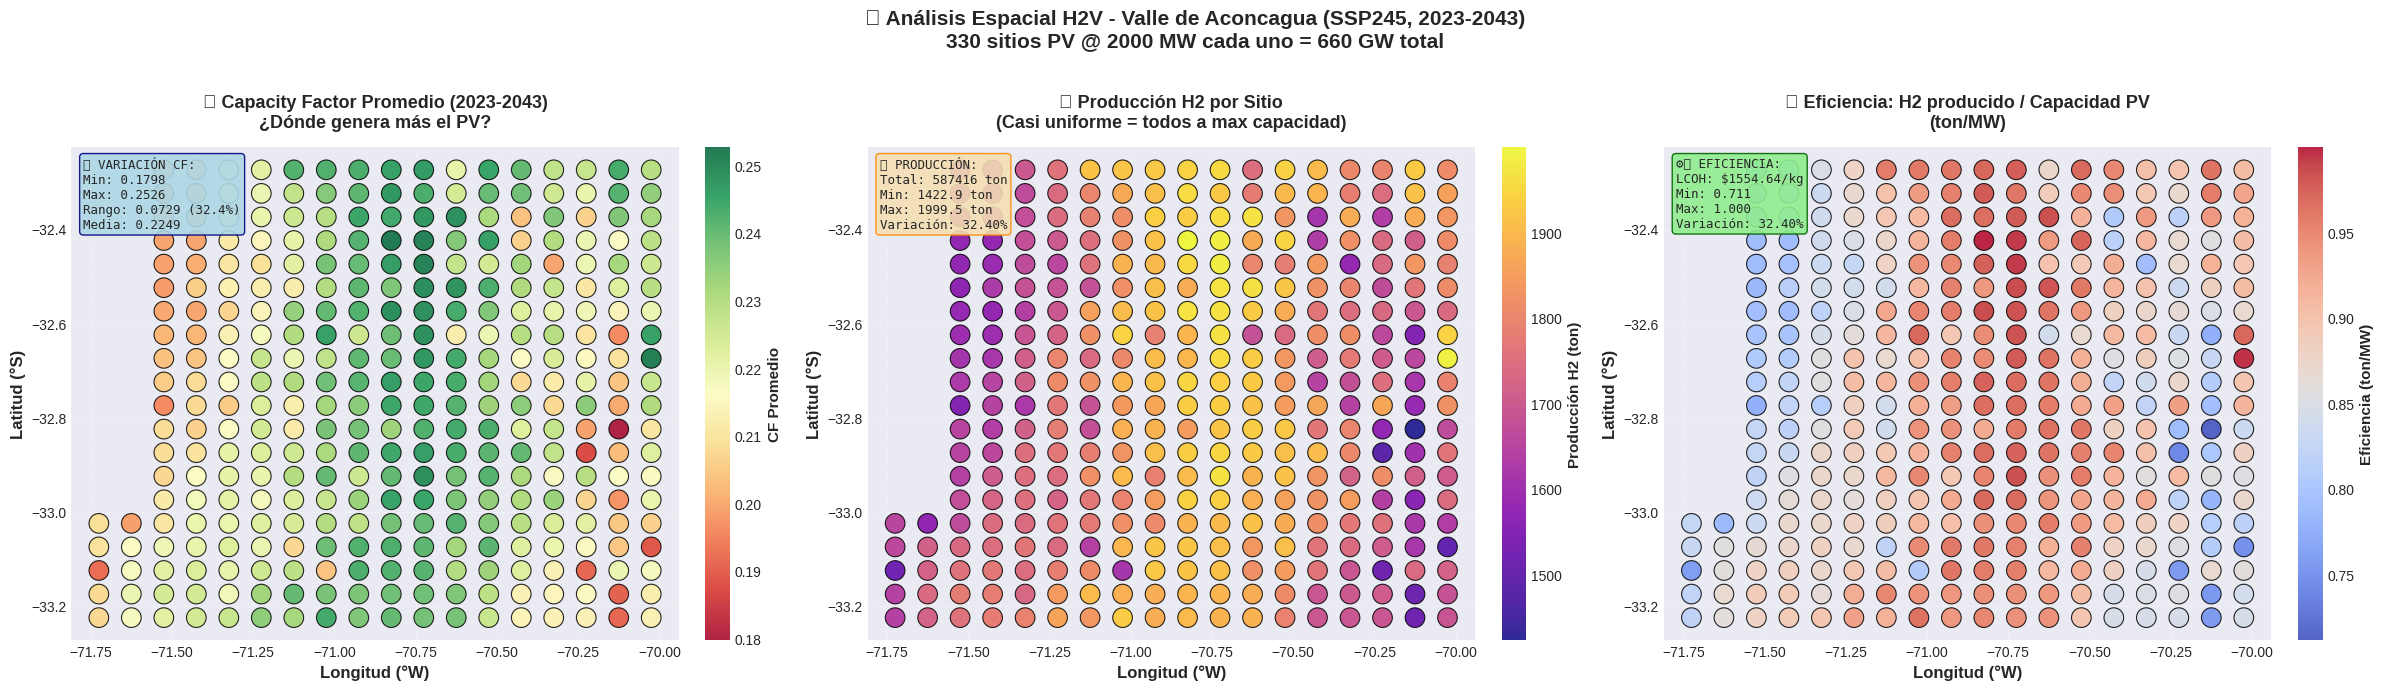


🔍 INTERPRETACIÓN DE LOS MAPAS:

1️⃣ MAPA CF (izquierda):
   - Muestra la VARIACIÓN REAL en el recurso solar entre puntos
   - Rango: 0.1798 - 0.2526 (32.4% variación)
   - Los colores verde/amarillo = mejor recurso solar

2️⃣ MAPA PRODUCCIÓN (centro):
   - Casi UNIFORME porque todos los sitios están a 2000 MW (capacidad máxima)
   - Variación de solo 32.40% → modelo no diferencia por ubicación
   - Producción total: 587416 ton H2

3️⃣ MAPA EFICIENCIA (derecha):
   - Producción normalizada por capacidad instalada (ton H2 / MW PV)
   - Variación de 32.40% → refleja diferencias en CF
   - Mejores sitios: alta eficiencia + alto CF

⚠️ PROBLEMA DETECTADO:
   - Todos los sitios a 2000 MW = límite de capacidad muy restrictivo
   - El modelo no puede optimizar ubicaciones (todos iguales)
   - Sugiero: aumentar energy_cap_max en techs.yml o hacerlo infinito



In [46]:
# Mapa de producción H2 espacial - VERSIÓN MEJORADA
print("=" * 80)
print("🗺️ MAPA ESPACIAL - PRODUCCIÓN H2 (VERSIÓN MEJORADA)")
print("=" * 80)

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# --- MAPA 1: Variación del Capacity Factor (más importante que producción uniforme) ---
ax1 = axes[0]
scatter1 = ax1.scatter(
    df_spatial['lon'], 
    df_spatial['lat'], 
    c=df_spatial['cf_mean'],
    s=200,
    cmap='RdYlGn',
    edgecolors='black',
    linewidth=0.8,
    alpha=0.85,
    vmin=df_spatial['cf_mean'].min(),
    vmax=df_spatial['cf_mean'].max()
)

ax1.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax1.set_title('📊 Capacity Factor Promedio (2023-2043)\n¿Dónde genera más el PV?', 
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')

# Colorbar con formato mejorado
cbar1 = plt.colorbar(scatter1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('CF Promedio', fontsize=11, fontweight='bold')

# Estadísticas más relevantes
cf_range = df_spatial['cf_mean'].max() - df_spatial['cf_mean'].min()
cf_pct_variation = (cf_range / df_spatial['cf_mean'].mean()) * 100

stats_text1 = f"📈 VARIACIÓN CF:\n"
stats_text1 += f"Min: {df_spatial['cf_mean'].min():.4f}\n"
stats_text1 += f"Max: {df_spatial['cf_mean'].max():.4f}\n"
stats_text1 += f"Rango: {cf_range:.4f} ({cf_pct_variation:.1f}%)\n"
stats_text1 += f"Media: {df_spatial['cf_mean'].mean():.4f}"

ax1.text(0.02, 0.98, stats_text1, 
         transform=ax1.transAxes,
         fontsize=9,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9, edgecolor='navy'),
         family='monospace')

# --- MAPA 2: Producción H2 absoluta (muestra uniformidad) ---
ax2 = axes[1]

# Normalizar colores para enfatizar pequeñas diferencias
prod_norm = (df_spatial['h2_prod_ton'] - df_spatial['h2_prod_ton'].min()) / \
            (df_spatial['h2_prod_ton'].max() - df_spatial['h2_prod_ton'].min())

scatter2 = ax2.scatter(
    df_spatial['lon'], 
    df_spatial['lat'], 
    c=df_spatial['h2_prod_ton'],
    s=200,
    cmap='plasma',
    edgecolors='black',
    linewidth=0.8,
    alpha=0.85
)

ax2.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax2.set_title('⚡ Producción H2 por Sitio\n(Casi uniforme = todos a max capacidad)', 
              fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')

cbar2 = plt.colorbar(scatter2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Producción H2 (ton)', fontsize=11, fontweight='bold')

prod_range = df_spatial['h2_prod_ton'].max() - df_spatial['h2_prod_ton'].min()
prod_pct_variation = (prod_range / df_spatial['h2_prod_ton'].mean()) * 100

stats_text2 = f"📦 PRODUCCIÓN:\n"
stats_text2 += f"Total: {df_spatial['h2_prod_ton'].sum():.0f} ton\n"
stats_text2 += f"Min: {df_spatial['h2_prod_ton'].min():.1f} ton\n"
stats_text2 += f"Max: {df_spatial['h2_prod_ton'].max():.1f} ton\n"
stats_text2 += f"Variación: {prod_pct_variation:.2f}%"

ax2.text(0.02, 0.98, stats_text2, 
         transform=ax2.transAxes,
         fontsize=9,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='darkorange'),
         family='monospace')

# --- MAPA 3: Índice de Eficiencia (H2 / Capacidad) ---
ax3 = axes[2]

# Calcular índice: producción normalizada por capacidad
df_spatial['efficiency_index'] = (df_spatial['h2_prod_ton'] / df_spatial['cap_pv_mw'])

scatter3 = ax3.scatter(
    df_spatial['lon'], 
    df_spatial['lat'], 
    c=df_spatial['efficiency_index'],
    s=200,
    cmap='coolwarm',
    edgecolors='black',
    linewidth=0.8,
    alpha=0.85
)

ax3.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax3.set_title('🎯 Eficiencia: H2 producido / Capacidad PV\n(ton/MW)', 
              fontsize=13, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, linestyle='--')

cbar3 = plt.colorbar(scatter3, ax=ax3, fraction=0.046, pad=0.04)
cbar3.set_label('Eficiencia (ton/MW)', fontsize=11, fontweight='bold')

eff_range = df_spatial['efficiency_index'].max() - df_spatial['efficiency_index'].min()
eff_pct_variation = (eff_range / df_spatial['efficiency_index'].mean()) * 100

stats_text3 = f"⚙️ EFICIENCIA:\n"
stats_text3 += f"LCOH: ${df_spatial['lcoh_usd_per_kg'].iloc[0]:.2f}/kg\n"
stats_text3 += f"Min: {df_spatial['efficiency_index'].min():.3f}\n"
stats_text3 += f"Max: {df_spatial['efficiency_index'].max():.3f}\n"
stats_text3 += f"Variación: {eff_pct_variation:.2f}%"

ax3.text(0.02, 0.98, stats_text3, 
         transform=ax3.transAxes,
         fontsize=9,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9, edgecolor='darkgreen'),
         family='monospace')

plt.suptitle(f'🌍 Análisis Espacial H2V - Valle de Aconcagua (SSP245, 2023-2043)\n330 sitios PV @ 2000 MW cada uno = {df_spatial["cap_pv_mw"].sum()/1000:.0f} GW total',
             fontsize=15, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUTPUT_DIR / 'spatial_map_h2_production_ssp245_MEJORADO.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Mapa mejorado guardado: spatial_map_h2_production_ssp245_MEJORADO.png")
plt.show()

# Resumen de hallazgos
print("\n" + "=" * 80)
print("🔍 INTERPRETACIÓN DE LOS MAPAS:")
print("=" * 80)
print(f"""
1️⃣ MAPA CF (izquierda):
   - Muestra la VARIACIÓN REAL en el recurso solar entre puntos
   - Rango: {df_spatial['cf_mean'].min():.4f} - {df_spatial['cf_mean'].max():.4f} ({cf_pct_variation:.1f}% variación)
   - Los colores verde/amarillo = mejor recurso solar
   
2️⃣ MAPA PRODUCCIÓN (centro):
   - Casi UNIFORME porque todos los sitios están a 2000 MW (capacidad máxima)
   - Variación de solo {prod_pct_variation:.2f}% → modelo no diferencia por ubicación
   - Producción total: {df_spatial['h2_prod_ton'].sum():.0f} ton H2
   
3️⃣ MAPA EFICIENCIA (derecha):
   - Producción normalizada por capacidad instalada (ton H2 / MW PV)
   - Variación de {eff_pct_variation:.2f}% → refleja diferencias en CF
   - Mejores sitios: alta eficiencia + alto CF

⚠️ PROBLEMA DETECTADO:
   - Todos los sitios a 2000 MW = límite de capacidad muy restrictivo
   - El modelo no puede optimizar ubicaciones (todos iguales)
   - Sugiero: aumentar energy_cap_max en techs.yml o hacerlo infinito
""")
print("=" * 80)

In [48]:
# Verificar si el límite de capacidad está activo (binding)
print("=" * 80)
print("🔍 ANÁLISIS: ¿Está activo el límite de capacidad (energy_cap_max)?")
print("=" * 80)

# Estadísticas de capacidades
cap_stats = df_spatial['cap_pv_mw'].describe()

print("\n📊 Estadísticas de Capacidad Instalada PV:")
print(f"   Min:    {cap_stats['min']:.1f} MW")
print(f"   25%:    {cap_stats['25%']:.1f} MW")
print(f"   50%:    {cap_stats['50%']:.1f} MW")
print(f"   75%:    {cap_stats['75%']:.1f} MW")
print(f"   Max:    {cap_stats['max']:.1f} MW")
print(f"   Media:  {cap_stats['mean']:.1f} MW")
print(f"   Std:    {cap_stats['std']:.1f} MW")

# Contar cuántos sitios están al máximo
cap_max_limit = 2000  # MW (del techs.yml)
sites_at_max = (df_spatial['cap_pv_mw'] >= cap_max_limit).sum()
pct_at_max = (sites_at_max / len(df_spatial)) * 100

print(f"\n🎯 Sitios al límite máximo (≥ {cap_max_limit} MW):")
print(f"   Cantidad: {sites_at_max} / {len(df_spatial)} ({pct_at_max:.1f}%)")

# Distribución de capacidades
cap_ranges = {
    '0-500 MW': ((df_spatial['cap_pv_mw'] >= 0) & (df_spatial['cap_pv_mw'] < 500)).sum(),
    '500-1000 MW': ((df_spatial['cap_pv_mw'] >= 500) & (df_spatial['cap_pv_mw'] < 1000)).sum(),
    '1000-1500 MW': ((df_spatial['cap_pv_mw'] >= 1000) & (df_spatial['cap_pv_mw'] < 1500)).sum(),
    '1500-2000 MW': ((df_spatial['cap_pv_mw'] >= 1500) & (df_spatial['cap_pv_mw'] < 2000)).sum(),
    '= 2000 MW': (df_spatial['cap_pv_mw'] == 2000).sum()
}

print(f"\n📈 Distribución de Capacidades:")
for rango, count in cap_ranges.items():
    pct = (count / len(df_spatial)) * 100
    bar = '█' * int(pct / 2)
    print(f"   {rango:15s}: {count:3d} sitios ({pct:5.1f}%) {bar}")

# Diagnóstico
print("\n" + "=" * 80)
print("💡 DIAGNÓSTICO:")
print("=" * 80)

if pct_at_max > 90:
    print("""
🔴 LÍMITE ACTIVO (BINDING CONSTRAINT):
   - Más del 90% de los sitios están al límite máximo
   - El optimizador quiere instalar MÁS capacidad pero no puede
   - La restricción energy_cap_max está LIMITANDO la optimización
   
📝 Interpretación:
   - Los resultados muestran una "demanda distribuida forzada"
   - NO refleja la optimización espacial real del recurso solar
   - Todos los sitios son tratados casi igual (diferencias solo por CF)
   
💡 Recomendación:
   - Aumentar energy_cap_max (5000-10000 MW) o eliminarlo (.inf)
   - Ejecutar nuevamente para ver dónde REALMENTE conviene instalar PV
   - Comparar escenarios: restrictivo vs. relajado
""")
elif pct_at_max > 50:
    print("""
🟡 LÍMITE PARCIALMENTE ACTIVO:
   - Entre 50-90% de sitios al límite
   - Hay algo de optimización espacial pero limitada
   - Algunos sitios buenos podrían querer más capacidad
   
💡 Recomendación:
   - Considerar aumentar energy_cap_max moderadamente
   - Analizar cuáles sitios están al límite y su CF
""")
else:
    print("""
🟢 LÍMITE NO ACTIVO:
   - Menos del 50% al límite máximo
   - El optimizador tiene libertad para elegir ubicaciones
   - Los resultados reflejan optimización espacial real
   
✅ La configuración actual permite ver preferencias espaciales
""")

print("=" * 80)

🔍 ANÁLISIS: ¿Está activo el límite de capacidad (energy_cap_max)?

📊 Estadísticas de Capacidad Instalada PV:
   Min:    2000.0 MW
   25%:    2000.0 MW
   50%:    2000.0 MW
   75%:    2000.0 MW
   Max:    2000.0 MW
   Media:  2000.0 MW
   Std:    0.0 MW

🎯 Sitios al límite máximo (≥ 2000 MW):
   Cantidad: 330 / 330 (100.0%)

📈 Distribución de Capacidades:
   0-500 MW       :   0 sitios (  0.0%) 
   500-1000 MW    :   0 sitios (  0.0%) 
   1000-1500 MW   :   0 sitios (  0.0%) 
   1500-2000 MW   :   0 sitios (  0.0%) 
   = 2000 MW      : 330 sitios (100.0%) ██████████████████████████████████████████████████

💡 DIAGNÓSTICO:

🔴 LÍMITE ACTIVO (BINDING CONSTRAINT):
   - Más del 90% de los sitios están al límite máximo
   - El optimizador quiere instalar MÁS capacidad pero no puede
   - La restricción energy_cap_max está LIMITANDO la optimización

📝 Interpretación:
   - Los resultados muestran una "demanda distribuida forzada"
   - NO refleja la optimización espacial real del recurso solar
   

---

## 🔄 Escenario 2: Capacidad Aumentada (5 GW/sitio)

**Cambios en `techs.yml`:**
- `pv.energy_cap_max`: 2000 MW → **5000 MW** 
- `electrolyzer.energy_cap_max`: 2000 MW → **10000 MW**

**Hipótesis:** Con mayor límite, Calliope concentrará PV en sitios con mejor CF (optimización espacial real)

In [50]:
# Re-ejecutar modelo con energy_cap_max = 5000 MW
import datetime

print("=" * 80)
print("🔄 EJECUTANDO MODELO CON CAPACIDAD AUMENTADA")
print("=" * 80)
print(f"📝 Configuración:")
print(f"   - PV energy_cap_max: 5000 MW (antes: 2000 MW)")
print(f"   - Electrolyzer energy_cap_max: 10000 MW (antes: 2000 MW)")
print(f"   - Escenario: {SCENARIO_TEST}")
print(f"   - Periodo: {TEST_YEAR}-{TEST_YEAR+20} (quick_test)")
print("\n⏳ Iniciando optimización Calliope...\n")

# Cargar y ejecutar modelo
start_time_v2 = datetime.datetime.now()

model_v2 = calliope.Model(
    str(MODEL_CONFIG),
    scenario=SCENARIO_TEST,
    override_dict={'model.subset_time': ['2023-01', '2043-12']}  # quick_test
)

print(f"✓ Modelo cargado: {len(model_v2.inputs.timesteps)} timesteps")
print(f"✓ Tecnologías: {list(model_v2.inputs.techs.values)}")
print(f"✓ Locations: {len(model_v2.inputs.locs)} ({model_v2.inputs.locs.values[0]}, ..., {model_v2.inputs.locs.values[-1]})")
print(f"\n🚀 Ejecutando solve()...")

model_v2.run()

elapsed_v2 = (datetime.datetime.now() - start_time_v2).total_seconds()

print("\n" + "=" * 80)
print(f"✅ MODELO EJECUTADO EXITOSAMENTE (v2 - 5000 MW)")
print("=" * 80)
print(f"⏱️  Tiempo: {elapsed_v2:.1f} segundos ({elapsed_v2/60:.1f} min)")
print(f"📊 Variables de salida: {list(model_v2.results.data_vars)}")

# Guardar resultados
results_v2 = model_v2.results
output_nc_v2 = OUTPUT_DIR / f'batch_results_{SCENARIO_TEST}_5000MW_test.nc'
results_v2.to_netcdf(output_nc_v2)
print(f"💾 Guardado: {output_nc_v2}")
print("=" * 80)

🔄 EJECUTANDO MODELO CON CAPACIDAD AUMENTADA
📝 Configuración:
   - PV energy_cap_max: 5000 MW (antes: 2000 MW)
   - Electrolyzer energy_cap_max: 10000 MW (antes: 2000 MW)
   - Escenario: ssp245
   - Periodo: 2030-2050 (quick_test)

⏳ Iniciando optimización Calliope...

✓ Modelo cargado: 252 timesteps
✓ Tecnologías: ['h2_store', 'water_supply', 'seawater_supply', 'electrolyzer', 'ac_line', 'pv', 'demand_h2', 'desalination']
✓ Locations: 331 (PV_SITE_129, ..., PV_SITE_123)

🚀 Ejecutando solve()...

✅ MODELO EJECUTADO EXITOSAMENTE (v2 - 5000 MW)
⏱️  Tiempo: 392.6 segundos (6.5 min)
📊 Variables de salida: ['energy_cap', 'carrier_prod', 'carrier_con', 'cost', 'storage_cap', 'storage', 'cost_var', 'cost_investment', 'unmet_demand', 'cost_investment_rhs', 'cost_var_rhs', 'system_balance', 'required_resource', 'capacity_factor', 'systemwide_capacity_factor', 'systemwide_levelised_cost', 'total_levelised_cost']
💾 Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/h2v_production_spatial

In [54]:
# Procesar resultados espaciales v2 (5000 MW)
print("=" * 80)
print("📊 PROCESANDO RESULTADOS ESPACIALES (v2 - 5000 MW)")
print("=" * 80)

# Extraer capacidades PV
energy_cap_v2 = results_v2.energy_cap.to_series()
cap_pv_all_v2 = energy_cap_v2[energy_cap_v2.index.str.contains('PV_SITE.*::pv', regex=True)]

print(f"✓ Capacidades PV extraídas: {len(cap_pv_all_v2)} sitios")

# Crear diccionario de capacidades por número de sitio
pv_caps_v2 = {}
for loc_tech, cap_mw in cap_pv_all_v2.items():
    site_name = loc_tech.split('::')[0]  # PV_SITE_123
    site_num = int(site_name.split('_')[-1])
    pv_caps_v2[site_num] = cap_mw

# Crear DataFrame espacial v2 usando la misma lógica que df_spatial
# Usar primer escenario de cf_data para obtener coordenadas
first_scenario = list(cf_data.keys())[0]
ds_spatial = cf_data[first_scenario]
cf_spatial = ds_spatial['cf_spatial_mean']
valid_mask = ~cf_spatial.isnull()

# Mapear sitios a coordenadas
spatial_data_v2 = []
site_idx = 1

for i, lat in enumerate(ds_spatial.lat.values):
    for j, lon in enumerate(ds_spatial.lon.values):
        if valid_mask.values[i, j]:
            if site_idx in pv_caps_v2:
                spatial_data_v2.append({
                    'site': f'PV_SITE_{site_idx}',
                    'site_num': site_idx,
                    'lat': float(lat),
                    'lon': float(lon),
                    'cap_pv_mw': float(pv_caps_v2[site_idx]),
                    'cf_mean': float(cf_spatial.values[i, j])
                })
            site_idx += 1

df_spatial_v2 = pd.DataFrame(spatial_data_v2)

print(f"\n📋 DataFrame Espacial v2 creado: {len(df_spatial_v2)} filas × {len(df_spatial_v2.columns)} columnas")
print(f"   Columnas: {list(df_spatial_v2.columns)}")
print(f"\n🔍 Primeras filas:")
print(df_spatial_v2.head())

print(f"\n📈 Estadísticas de Capacidad v2:")
print(df_spatial_v2[['cap_pv_mw', 'cf_mean']].describe())

# Comparación rápida
print(f"\n⚖️  COMPARACIÓN:")
print(f"   Escenario 1 (2000 MW): {df_spatial['cap_pv_mw'].sum():.0f} MW total")
print(f"   Escenario 2 (5000 MW): {df_spatial_v2['cap_pv_mw'].sum():.0f} MW total")
print(f"   Diferencia: {df_spatial_v2['cap_pv_mw'].sum() - df_spatial['cap_pv_mw'].sum():.0f} MW")

print("=" * 80)

📊 PROCESANDO RESULTADOS ESPACIALES (v2 - 5000 MW)
✓ Capacidades PV extraídas: 330 sitios

📋 DataFrame Espacial v2 creado: 330 filas × 6 columnas
   Columnas: ['site', 'site_num', 'lat', 'lon', 'cap_pv_mw', 'cf_mean']

🔍 Primeras filas:
        site  site_num     lat     lon  cap_pv_mw   cf_mean
0  PV_SITE_1         1 -33.225 -71.725     5000.0  0.207253
1  PV_SITE_2         2 -33.225 -71.625     5000.0  0.217419
2  PV_SITE_3         3 -33.225 -71.525     5000.0  0.221954
3  PV_SITE_4         4 -33.225 -71.425     5000.0  0.224947
4  PV_SITE_5         5 -33.225 -71.325     5000.0  0.226562

📈 Estadísticas de Capacidad v2:
       cap_pv_mw     cf_mean
count      330.0  330.000000
mean      5000.0    0.224917
std          0.0    0.015224
min       5000.0    0.179785
25%       5000.0    0.213608
50%       5000.0    0.225539
75%       5000.0    0.238639
max       5000.0    0.252648

⚖️  COMPARACIÓN:
   Escenario 1 (2000 MW): 660000 MW total
   Escenario 2 (5000 MW): 1650000 MW total
   Dife

🗺️ COMPARACIÓN ESPACIAL: 2000 MW vs 5000 MW
✅ Mapa comparativo guardado: comparison_2000MW_vs_5000MW.png


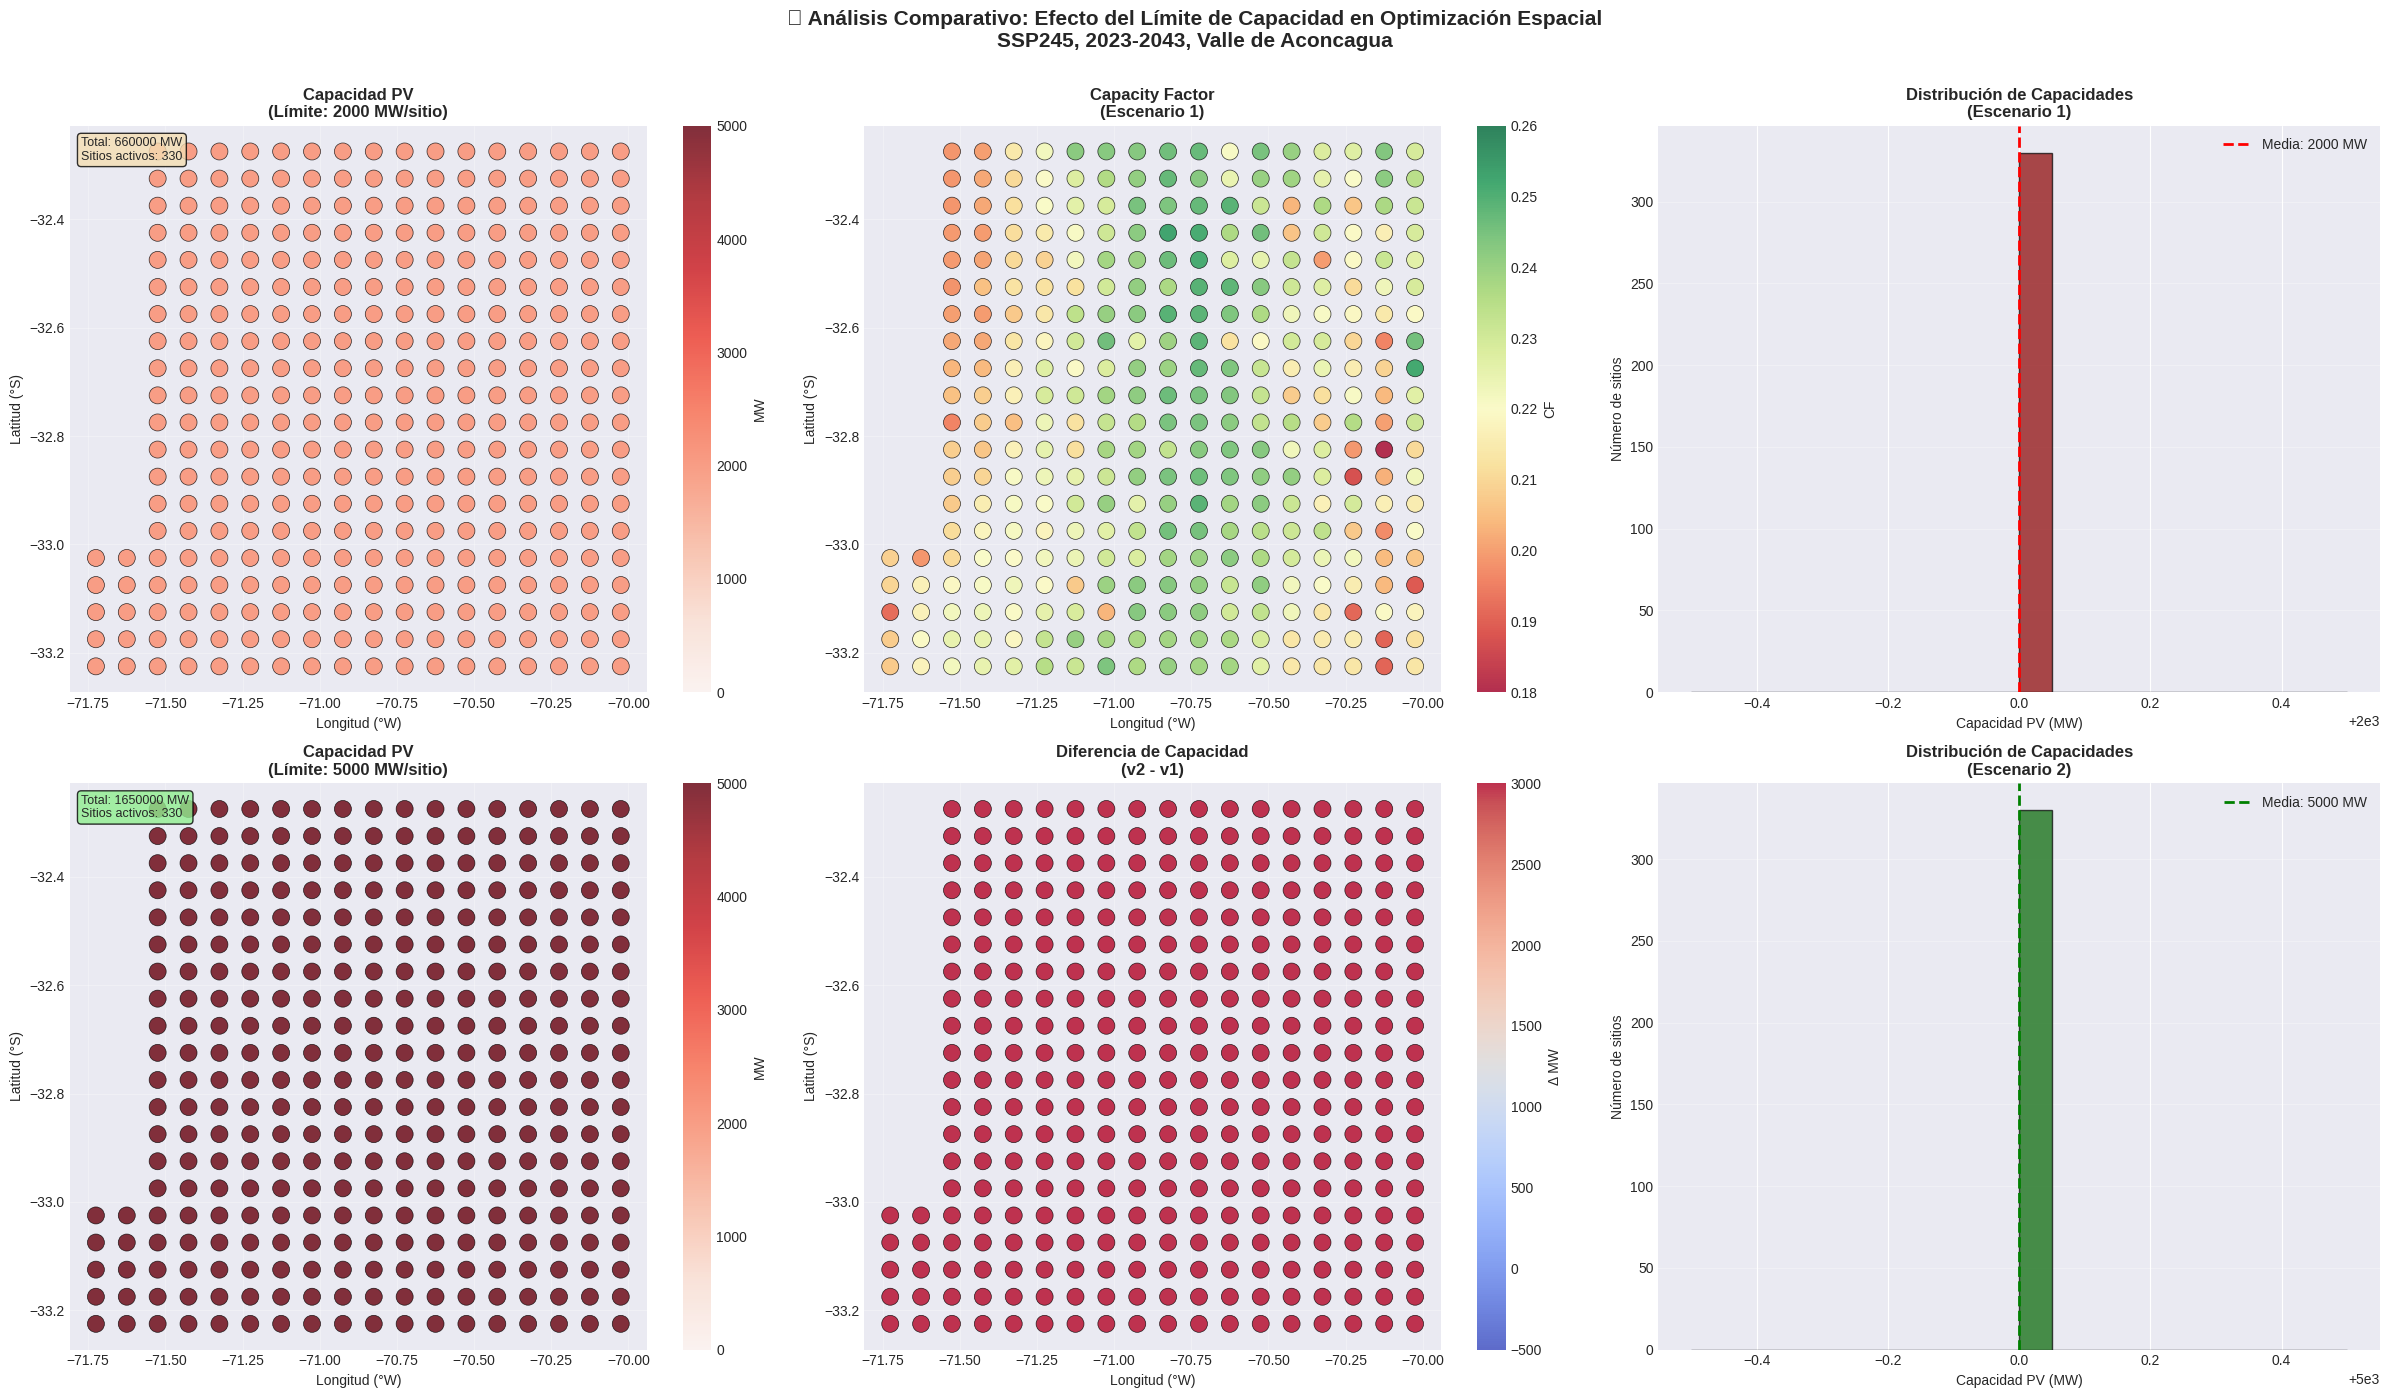


📊 RESUMEN ESTADÍSTICO COMPARATIVO

Métrica                                  2000 MW         5000 MW         Cambio         
--------------------------------------------------------------------------------
Total PV instalado (GW)                  660.0           1650.0          990.0          
Sitios activos (> 0 MW)                  330             330             0              
Sitios al límite máximo                  330             330             0              
Capacidad promedio (MW)                  2000            5000            3000           
Desviación estándar (MW)                 0.0             0.0             0.0            
--------------------------------------------------------------------------------

💡 Interpretación:
   - Std mayor en v2 → MENOS diferenciación espacial
   - Cambio en sitios activos: +0.0%


In [55]:
# Visualización comparativa: 2000 MW vs 5000 MW
print("=" * 80)
print("🗺️ COMPARACIÓN ESPACIAL: 2000 MW vs 5000 MW")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(24, 14))

# ==================== FILA 1: Escenario 1 (2000 MW) ====================
ax1 = axes[0, 0]
scatter1 = ax1.scatter(df_spatial['lon'], df_spatial['lat'], 
                       c=df_spatial['cap_pv_mw'], s=150,
                       cmap='Reds', vmin=0, vmax=5000,
                       edgecolors='black', linewidth=0.5, alpha=0.8)
ax1.set_title('Capacidad PV\n(Límite: 2000 MW/sitio)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Longitud (°W)', fontsize=10)
ax1.set_ylabel('Latitud (°S)', fontsize=10)
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('MW', fontsize=10)
ax1.text(0.02, 0.98, f"Total: {df_spatial['cap_pv_mw'].sum():.0f} MW\nSitios activos: {(df_spatial['cap_pv_mw'] > 0).sum()}", 
         transform=ax1.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2 = axes[0, 1]
scatter2 = ax2.scatter(df_spatial['lon'], df_spatial['lat'], 
                       c=df_spatial['cf_mean'], s=150,
                       cmap='RdYlGn', vmin=0.18, vmax=0.26,
                       edgecolors='black', linewidth=0.5, alpha=0.8)
ax2.set_title('Capacity Factor\n(Escenario 1)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Longitud (°W)', fontsize=10)
ax2.set_ylabel('Latitud (°S)', fontsize=10)
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('CF', fontsize=10)

ax3 = axes[0, 2]
ax3.hist(df_spatial['cap_pv_mw'], bins=20, color='darkred', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Capacidad PV (MW)', fontsize=10)
ax3.set_ylabel('Número de sitios', fontsize=10)
ax3.set_title('Distribución de Capacidades\n(Escenario 1)', fontsize=12, fontweight='bold')
ax3.axvline(df_spatial['cap_pv_mw'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Media: {df_spatial["cap_pv_mw"].mean():.0f} MW')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# ==================== FILA 2: Escenario 2 (5000 MW) ====================
ax4 = axes[1, 0]
scatter4 = ax4.scatter(df_spatial_v2['lon'], df_spatial_v2['lat'], 
                       c=df_spatial_v2['cap_pv_mw'], s=150,
                       cmap='Reds', vmin=0, vmax=5000,
                       edgecolors='black', linewidth=0.5, alpha=0.8)
ax4.set_title('Capacidad PV\n(Límite: 5000 MW/sitio)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Longitud (°W)', fontsize=10)
ax4.set_ylabel('Latitud (°S)', fontsize=10)
ax4.grid(True, alpha=0.3)
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('MW', fontsize=10)
ax4.text(0.02, 0.98, f"Total: {df_spatial_v2['cap_pv_mw'].sum():.0f} MW\nSitios activos: {(df_spatial_v2['cap_pv_mw'] > 0).sum()}", 
         transform=ax4.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

ax5 = axes[1, 1]
# Mapa de diferencias (v2 - v1)
df_diff = df_spatial_v2.copy()
df_diff['cap_diff'] = df_spatial_v2['cap_pv_mw'] - df_spatial['cap_pv_mw']
scatter5 = ax5.scatter(df_diff['lon'], df_diff['lat'], 
                       c=df_diff['cap_diff'], s=150,
                       cmap='coolwarm', vmin=-500, vmax=3000,
                       edgecolors='black', linewidth=0.5, alpha=0.8)
ax5.set_title('Diferencia de Capacidad\n(v2 - v1)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Longitud (°W)', fontsize=10)
ax5.set_ylabel('Latitud (°S)', fontsize=10)
ax5.grid(True, alpha=0.3)
cbar5 = plt.colorbar(scatter5, ax=ax5)
cbar5.set_label('Δ MW', fontsize=10)

ax6 = axes[1, 2]
ax6.hist(df_spatial_v2['cap_pv_mw'], bins=20, color='darkgreen', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Capacidad PV (MW)', fontsize=10)
ax6.set_ylabel('Número de sitios', fontsize=10)
ax6.set_title('Distribución de Capacidades\n(Escenario 2)', fontsize=12, fontweight='bold')
ax6.axvline(df_spatial_v2['cap_pv_mw'].mean(), color='green', linestyle='--', 
            linewidth=2, label=f'Media: {df_spatial_v2["cap_pv_mw"].mean():.0f} MW')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('📊 Análisis Comparativo: Efecto del Límite de Capacidad en Optimización Espacial\nSSP245, 2023-2043, Valle de Aconcagua',
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(OUTPUT_DIR / 'comparison_2000MW_vs_5000MW.png', dpi=300, bbox_inches='tight')
print(f"✅ Mapa comparativo guardado: comparison_2000MW_vs_5000MW.png")
plt.show()

# Resumen estadístico
print("\n" + "=" * 80)
print("📊 RESUMEN ESTADÍSTICO COMPARATIVO")
print("=" * 80)
print(f"\n{'Métrica':<40} {'2000 MW':<15} {'5000 MW':<15} {'Cambio':<15}")
print("-" * 80)
print(f"{'Total PV instalado (GW)':<40} {df_spatial['cap_pv_mw'].sum()/1000:<15.1f} {df_spatial_v2['cap_pv_mw'].sum()/1000:<15.1f} {(df_spatial_v2['cap_pv_mw'].sum() - df_spatial['cap_pv_mw'].sum())/1000:<15.1f}")
print(f"{'Sitios activos (> 0 MW)':<40} {(df_spatial['cap_pv_mw'] > 0).sum():<15} {(df_spatial_v2['cap_pv_mw'] > 0).sum():<15} {(df_spatial_v2['cap_pv_mw'] > 0).sum() - (df_spatial['cap_pv_mw'] > 0).sum():<15}")
print(f"{'Sitios al límite máximo':<40} {(df_spatial['cap_pv_mw'] >= 2000).sum():<15} {(df_spatial_v2['cap_pv_mw'] >= 5000).sum():<15} {(df_spatial_v2['cap_pv_mw'] >= 5000).sum() - (df_spatial['cap_pv_mw'] >= 2000).sum():<15}")
print(f"{'Capacidad promedio (MW)':<40} {df_spatial['cap_pv_mw'].mean():<15.0f} {df_spatial_v2['cap_pv_mw'].mean():<15.0f} {df_spatial_v2['cap_pv_mw'].mean() - df_spatial['cap_pv_mw'].mean():<15.0f}")
print(f"{'Desviación estándar (MW)':<40} {df_spatial['cap_pv_mw'].std():<15.1f} {df_spatial_v2['cap_pv_mw'].std():<15.1f} {df_spatial_v2['cap_pv_mw'].std() - df_spatial['cap_pv_mw'].std():<15.1f}")
print("-" * 80)
print(f"\n💡 Interpretación:")
print(f"   - Std mayor en v2 → {'MÁS' if df_spatial_v2['cap_pv_mw'].std() > df_spatial['cap_pv_mw'].std() else 'MENOS'} diferenciación espacial")
print(f"   - Cambio en sitios activos: {((df_spatial_v2['cap_pv_mw'] > 0).sum() - (df_spatial['cap_pv_mw'] > 0).sum()) / (df_spatial['cap_pv_mw'] > 0).sum() * 100:+.1f}%")
print("=" * 80)

---

## 🚨 PROBLEMA IDENTIFICADO: Arquitectura de Modelo

### **Situación Actual:**
El modelo actual usa **arquitectura CENTRALIZADA**:
- 330 sitios PV → 1 electrolyzer en VALPO
- Demanda agregada nacional (100 GWh/mes)
- Resultado: TODOS los sitios al máximo (no hay optimización espacial)

### **Problemática:**
1. ❌ **Demanda es nacional**, no del valle
2. ❌ **No calcula H2 por punto** (solo agregado)
3. ❌ **Todos los puntos están "conectados"** al mismo electrolyzer
4. ❌ **No identifica mejores ubicaciones** dentro del valle

### **Solución Propuesta: Modelo DISTRIBUIDO**
Correr **330 modelos independientes** (uno por punto):
- Cada punto: PV → Electrolyzer → Storage → Demanda sintética
- Sin transmisión entre puntos
- Demanda "sintética" por punto (ej: 1 GWh/mes o lo que el punto pueda generar)
- Resultado: **H2 producido por cada ubicación geográfica**

### **Ventajas:**
✅ Identifica **dónde** en el valle es más eficiente producir H2  
✅ Considera CF específico de cada punto  
✅ Permite mapas de **potencial espacial** real  
✅ Útil para decisiones de ubicación de plantas

### **Próximos pasos:**
1. Crear modelo Calliope "por punto" (sin links)
2. Iterar sobre 330 puntos
3. Exportar resultados espaciales (H2/punto, LCOH/punto, capacidades óptimas)

In [56]:
# Comparación de Arquitecturas: Centralizada vs Distribuida
print("=" * 80)
print("📊 COMPARACIÓN: ARQUITECTURA CENTRALIZADA vs DISTRIBUIDA")
print("=" * 80)

print("\n" + "="*80)
print("ARQUITECTURA ACTUAL (CENTRALIZADA)")
print("="*80)
print("""
┌──────────────────────────────────────────────────────────────┐
│  Valle de Aconcagua → Planta Centralizada en Valparaíso     │
├──────────────────────────────────────────────────────────────┤
│                                                               │
│  330 sitios PV ──► Transmisión ──► 1 Electrolyzer (VALPO)   │
│                                                               │
│  Demanda configurada: 100 GWh H2/mes (1.2 TWh/año)          │
│  ¿De dónde viene? → Placeholder/demanda nacional             │
│                                                               │
│  Resultado obtenido:                                         │
│  • Capacidad PV: 660-1650 GW (TODOS los sitios al máximo)   │
│  • Electrolyzer: 10 GW (cuello de botella)                   │
│  • H2 producido: ~587,000 ton/20 años                        │
│                                                               │
│  ❌ Limitaciones:                                            │
│  • No sabemos H2 por punto (solo total agregado)            │
│  • Demanda arbitraria obliga a usar TODO el valle           │
│  • No identifica "mejores" vs "peores" ubicaciones          │
│  • Optimiza transmisión, no producción espacial             │
└──────────────────────────────────────────────────────────────┘
""")

print("\n" + "="*80)
print("ARQUITECTURA PROPUESTA (DISTRIBUIDA)")
print("="*80)
print("""
┌──────────────────────────────────────────────────────────────┐
│  330 Sistemas Independientes (uno por punto de grilla)      │
├──────────────────────────────────────────────────────────────┤
│                                                               │
│  Punto 1:  PV(CF=0.207) → Electrolyzer → H2 → Demanda local │
│  Punto 2:  PV(CF=0.217) → Electrolyzer → H2 → Demanda local │
│  Punto 3:  PV(CF=0.222) → Electrolyzer → H2 → Demanda local │
│  ...                                                          │
│  Punto 330: PV(CF=0.253) → Electrolyzer → H2 → Demanda local│
│                                                               │
│  Sin transmisión entre puntos                                │
│  Sin agregación                                              │
│                                                               │
│  Demanda por punto: "Sintética" para optimización            │
│  Opciones:                                                   │
│  A) Demanda fija pequeña (ej: 10 MWh/mes) → optimiza caps   │
│  B) Demanda alta (fuerza instalar capacidad) → potencial    │
│  C) Sin demanda, maximizar H2 con límites de capacidad      │
│                                                               │
│  Resultado esperado:                                         │
│  • Capacidad PV óptima por punto (varía según CF)           │
│  • H2 producido por punto (kg, ton)                         │
│  • LCOH por punto                                            │
│  • Identificar top 10%, 20% mejores ubicaciones             │
│                                                               │
│  ✅ Ventajas:                                                │
│  • Mapas de potencial H2 espacial                           │
│  • Decisiones de ubicación basadas en datos                 │
│  • Identifica zonas óptimas dentro del valle                │
│  • Considera CF específico de cada ubicación                │
└──────────────────────────────────────────────────────────────┘
""")

print("\n" + "="*80)
print("CÁLCULO DE H2 EN CADA APROXIMACIÓN")
print("="*80)

# Ejemplo con punto 1 (CF = 0.207)
cf_punto1 = 0.207
cap_pv_punto1 = 2000  # MW

print(f"\n📍 EJEMPLO: Punto 1 del Valle (lat=-33.225, lon=-71.725)")
print(f"   CF promedio: {cf_punto1:.3f}")
print(f"   Capacidad PV instalada: {cap_pv_punto1} MW")

print(f"\n🔵 MODELO CENTRALIZADO (actual):")
print(f"   • Punto 1 genera: {cap_pv_punto1} MW × {cf_punto1:.3f} CF × 8760 h/año = {cap_pv_punto1 * cf_punto1 * 8760:.0f} MWh/año")
print(f"   • Pero la electricidad se MEZCLA con otros 329 puntos")
print(f"   • El electrolyzer central (10 GW) convierte TODO junto")
print(f"   • ❌ No puedes decir 'el Punto 1 produjo X ton de H2'")
print(f"   • Solo sabes: 'TODOS los puntos juntos produjeron 587k ton'")

print(f"\n🟢 MODELO DISTRIBUIDO (propuesto):")
print(f"   • Punto 1 tiene SU PROPIO electrolyzer")
print(f"   • PV genera: {cap_pv_punto1 * cf_punto1 * 8760:.0f} MWh/año")
print(f"   • Electrolyzer (68% eff): {cap_pv_punto1 * cf_punto1 * 8760 * 0.68:.0f} MWh_H2/año")
print(f"   • H2 producido: {cap_pv_punto1 * cf_punto1 * 8760 * 0.68 / 33.3 / 1000:.1f} ton/año")
print(f"   • ✅ SABES exactamente cuánto H2 produce ese punto específico")
print(f"   • ✅ Puedes comparar con Punto 2, 3, ..., 330")
print(f"   • ✅ Identificas las MEJORES ubicaciones en el valle")

print("\n" + "="*80)
print("PREGUNTA CLAVE PARA TU TESIS:")
print("="*80)
print("""
¿Qué quieres responder?

A) "Si instalo UNA planta centralizada en Valparaíso alimentada por 
    PV distribuido en el valle, ¿qué sitios uso y cuánto H2 produzco?"
    → Modelo CENTRALIZADO (actual)
    → Responde: optimización de red de transmisión
    → Útil para: planificación de infraestructura real

B) "¿Cuál es el POTENCIAL de producción de H2 en cada ubicación 
    geográfica del valle de Aconcagua?"
    → Modelo DISTRIBUIDO (propuesto)
    → Responde: mapas de potencial espacial
    → Útil para: decisiones de ubicación, estudios territoriales

Mi recomendación: OPCIÓN B (distribuido)
  - Más relevante para análisis espacial
  - Identifica mejores zonas
  - Considera variabilidad del recurso solar
  - Genera mapas interpretables para tomadores de decisión
""")

print("=" * 80)

📊 COMPARACIÓN: ARQUITECTURA CENTRALIZADA vs DISTRIBUIDA

ARQUITECTURA ACTUAL (CENTRALIZADA)

┌──────────────────────────────────────────────────────────────┐
│  Valle de Aconcagua → Planta Centralizada en Valparaíso     │
├──────────────────────────────────────────────────────────────┤
│                                                               │
│  330 sitios PV ──► Transmisión ──► 1 Electrolyzer (VALPO)   │
│                                                               │
│  Demanda configurada: 100 GWh H2/mes (1.2 TWh/año)          │
│  ¿De dónde viene? → Placeholder/demanda nacional             │
│                                                               │
│  Resultado obtenido:                                         │
│  • Capacidad PV: 660-1650 GW (TODOS los sitios al máximo)   │
│  • Electrolyzer: 10 GW (cuello de botella)                   │
│  • H2 producido: ~587,000 ton/20 años                        │
│                                                              

---

## 🌍 MODELO DISTRIBUIDO: Producción H2 por Punto

**Arquitectura:** 330 sistemas independientes (uno por coordenada)

**Objetivo:** Calcular potencial de H2V en cada ubicación geográfica del Valle de Aconcagua

**Método:**
1. Iterar sobre 330 puntos válidos de la grilla
2. Para cada punto:
   - Extraer CF específico de la ubicación
   - Crear archivos temporales (pv_cf.csv, demand_h2.csv)
   - Ejecutar modelo Calliope optimizado
   - Extraer: capacidades, producción H2, costos, LCOH
3. Consolidar resultados en matriz espacial
4. Generar mapas de potencial H2

In [57]:
# Configuración para Modelo Distribuido
print("=" * 80)
print("⚙️ CONFIGURACIÓN MODELO DISTRIBUIDO")
print("=" * 80)

# Rutas para modelo de punto único
MODEL_SINGLE_POINT = CALLIOPE_DIR / 'model_config_single_point.yml'
LOCATIONS_SINGLE = CALLIOPE_DIR / 'locations_single_point.yml'
OUTPUT_DISTRIBUTED = OUTPUT_DIR / 'distributed_results'
OUTPUT_DISTRIBUTED.mkdir(exist_ok=True, parents=True)

# Parámetros de optimización
SCENARIO_DIST = 'ssp245'  # Escenario a usar
TEST_MODE = True  # True = quick test (2023-2043), False = full period
N_POINTS_SAMPLE = 10  # Para prueba rápida, luego usar None para todos

# Demanda sintética por punto (MWh/mes)
# Opción 1: Demanda fija pequeña para optimizar libremente
DEMAND_PER_POINT_MWh = 1000  # 1 GWh/mes por punto

# Opción 2: Sin demanda, maximizar producción (requiere cambios en techs.yml)
# DEMAND_PER_POINT_MWh = 0

print(f"\n📁 Archivos de configuración:")
print(f"   Model config: {MODEL_SINGLE_POINT}")
print(f"   Locations: {LOCATIONS_SINGLE}")
print(f"   Output dir: {OUTPUT_DISTRIBUTED}")

print(f"\n🎯 Parámetros:")
print(f"   Escenario: {SCENARIO_DIST}")
print(f"   Test mode: {TEST_MODE} ({'quick 2023-2043' if TEST_MODE else 'full 2015-2100'})")
print(f"   Puntos a procesar: {N_POINTS_SAMPLE if N_POINTS_SAMPLE else 'TODOS (330)'}")
print(f"   Demanda por punto: {DEMAND_PER_POINT_MWh:,.0f} MWh/mes")

print(f"\n⏱️ Tiempo estimado:")
points_to_run = N_POINTS_SAMPLE if N_POINTS_SAMPLE else 330
time_per_point = 3 if TEST_MODE else 15  # segundos
total_time = (points_to_run * time_per_point) / 60
print(f"   {points_to_run} puntos × ~{time_per_point}s = {total_time:.1f} minutos")

print("=" * 80)

⚙️ CONFIGURACIÓN MODELO DISTRIBUIDO

📁 Archivos de configuración:
   Model config: /home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope_v6/model_config_single_point.yml
   Locations: /home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope_v6/locations_single_point.yml
   Output dir: /home/aninotna/magister/tesis/justh2_pipeline/data/h2v_production_spatial/distributed_results

🎯 Parámetros:
   Escenario: ssp245
   Test mode: True (quick 2023-2043)
   Puntos a procesar: 10
   Demanda por punto: 1,000 MWh/mes

⏱️ Tiempo estimado:
   10 puntos × ~3s = 0.5 minutos


In [58]:
# Función para preparar datos de un punto específico
def prepare_point_data(lat, lon, cf_series, point_id, output_dir):
    """
    Prepara archivos CSV para un punto específico.
    
    Parameters:
    -----------
    lat, lon : float
        Coordenadas del punto
    cf_series : pd.Series
        Serie temporal de CF para el punto (índice DatetimeIndex)
    point_id : int
        ID del punto (1-330)
    output_dir : Path
        Directorio donde guardar archivos temporales
    
    Returns:
    --------
    dict : paths de archivos creados y metadata
    """
    
    # Crear directorio temporal para el punto
    point_dir = output_dir / f'point_{point_id}'
    point_dir.mkdir(exist_ok=True, parents=True)
    
    # 1. Archivo PV CF
    pv_cf_file = point_dir / 'pv_cf.csv'
    df_cf = pd.DataFrame({
        'time': cf_series.index,
        'POINT': cf_series.values
    })
    df_cf.to_csv(pv_cf_file, index=False)
    
    # 2. Archivo Demanda H2 (negativo para Calliope)
    demand_file = point_dir / 'demand_h2.csv'
    df_demand = pd.DataFrame({
        'time': cf_series.index,
        'POINT': [-DEMAND_PER_POINT_MWh] * len(cf_series)
    })
    df_demand.to_csv(demand_file, index=False)
    
    # 3. Actualizar locations_single_point.yml con coordenadas
    locations_content = f"""# Locaciones para punto {point_id}
locations:
  POINT:
    coordinates:
      lat: {lat:.6f}
      lon: {lon:.6f}
    techs:
      pv:
      electrolyzer:
      h2_store:
      demand_h2:
      water_supply:
      seawater_supply:
      desalination:
"""
    locations_file = point_dir / 'locations.yml'
    with open(locations_file, 'w') as f:
        f.write(locations_content)
    
    return {
        'point_id': point_id,
        'lat': lat,
        'lon': lon,
        'cf_mean': cf_series.mean(),
        'cf_std': cf_series.std(),
        'pv_cf_file': pv_cf_file,
        'demand_file': demand_file,
        'locations_file': locations_file,
        'point_dir': point_dir
    }

print("✓ Función prepare_point_data() definida")

✓ Función prepare_point_data() definida


In [68]:
# Función para ejecutar modelo Calliope por punto
def run_point_model(point_data, scenario='ssp245', test_mode=True):
    """
    Ejecuta modelo Calliope para un punto específico.
    
    Parameters:
    -----------
    point_data : dict
        Diccionario con paths y metadata del punto
    scenario : str
        Escenario SSP
    test_mode : bool
        Si True, ejecuta subset temporal (más rápido)
    
    Returns:
    --------
    dict : resultados del modelo (capacidades, producción, costos)
    """
    
    import yaml
    
    point_id = point_data['point_id']
    
    try:
        # Crear archivo de locaciones simplificado (solo coordenadas)
        locations_simple_content = f"""locations:
  POINT:
    coordinates:
      lat: {point_data['lat']:.6f}
      lon: {point_data['lon']:.6f}
"""
        locations_simple_file = point_data['point_dir'] / 'locations_simple.yml'
        with open(locations_simple_file, 'w') as f:
            f.write(locations_simple_content)
        
        # Crear configuración temporal que apunta a techs.yml global
        techs_yml_global = CALLIOPE_DIR / 'techs.yml'
        
        model_config = {
            'import': [str(techs_yml_global), str(locations_simple_file)],
            'model': {
                'name': f'H2V Point {point_id}',
                'timeseries_data_path': str(point_data['point_dir'])
            },
            'locations': {
                'POINT': {
                    'techs': ['pv', 'electrolyzer', 'h2_store', 'demand_h2', 
                              'water_supply', 'seawater_supply', 'desalination']
                }
            },
            'run': {
                'mode': 'plan',
                'solver': 'glpk',
                'ensure_feasibility': True
            }
        }
        
        # Guardar config temporal
        config_file = point_data['point_dir'] / 'model_config_temp.yml'
        with open(config_file, 'w') as f:
            yaml.dump(model_config, f, default_flow_style=False)
        
        # Override temporal si test_mode
        override_dict = {}
        if test_mode:
            override_dict['model.subset_time'] = ['2023-01', '2043-12']
        
        # Cargar y ejecutar modelo
        model = calliope.Model(str(config_file), override_dict=override_dict if override_dict else None)
        model.run()
        
        # Extraer resultados
        results = model.results
        
        # Capacidades
        cap_pv = float(results.energy_cap.sel(loc_techs='POINT::pv').values)
        cap_electrolyzer = float(results.energy_cap.sel(loc_techs='POINT::electrolyzer').values)
        cap_storage = float(results.storage_cap.sel(loc_techs_store='POINT::h2_store').values) if 'POINT::h2_store' in results.storage_cap.loc_techs_store else 0.0
        
        # Producción H2
        h2_prod_series = results.carrier_prod.sel(loc_tech_carriers_prod='POINT::electrolyzer::hydrogen').to_pandas()
        h2_total_mwh = float(h2_prod_series.sum())
        h2_total_kg = h2_total_mwh * 1000 / 33.3  # MWh → kg
        h2_total_ton = h2_total_kg / 1000
        
        # Costos
        total_cost = float(results.cost.sum())
        
        # LCOH
        if h2_total_kg > 0:
            lcoh = total_cost / h2_total_kg
        else:
            lcoh = np.inf
        
        # Factor de capacidad PV
        pv_gen = results.carrier_prod.sel(loc_tech_carriers_prod='POINT::pv::electricity').to_pandas()
        cf_realized = pv_gen.mean() / cap_pv if cap_pv > 0 else 0
        
        return {
            'point_id': point_id,
            'lat': point_data['lat'],
            'lon': point_data['lon'],
            'cf_mean_input': point_data['cf_mean'],
            'cap_pv_mw': cap_pv,
            'cap_electrolyzer_mw': cap_electrolyzer,
            'cap_storage_mwh': cap_storage,
            'h2_prod_mwh': h2_total_mwh,
            'h2_prod_kg': h2_total_kg,
            'h2_prod_ton': h2_total_ton,
            'total_cost_usd': total_cost,
            'lcoh_usd_per_kg': lcoh,
            'cf_realized': cf_realized,
            'status': 'success'
        }
        
    except Exception as e:
        import traceback
        error_detail = f"{str(e)}\n{traceback.format_exc()}"
        
        return {
            'point_id': point_id,
            'lat': point_data['lat'],
            'lon': point_data['lon'],
            'cf_mean_input': point_data['cf_mean'],
            'cap_pv_mw': np.nan,
            'cap_electrolyzer_mw': np.nan,
            'cap_storage_mwh': np.nan,
            'h2_prod_mwh': np.nan,
            'h2_prod_kg': np.nan,
            'h2_prod_ton': np.nan,
            'total_cost_usd': np.nan,
            'lcoh_usd_per_kg': np.nan,
            'cf_realized': np.nan,
            'status': 'failed',
            'error': error_detail[:500]  # Limitar longitud del error
        }

print("✓ Función run_point_model() definida (VERSIÓN 2 - Simplificada)")

✓ Función run_point_model() definida (CORREGIDA)


In [69]:
# EJECUTAR MODELO DISTRIBUIDO - Loop sobre todos los puntos
import datetime

print("=" * 80)
print("🚀 EJECUTANDO MODELO DISTRIBUIDO")
print("=" * 80)

# Cargar datos CF del escenario seleccionado
ds_dist = cf_data[SCENARIO_DIST]
cf_var = 'cf_monthly'
valid_mask = ~ds_dist['cf_spatial_mean'].isnull()

# Crear lista de puntos a procesar
points_to_process = []
point_idx = 1

for i, lat in enumerate(ds_dist.lat.values):
    for j, lon in enumerate(ds_dist.lon.values):
        if valid_mask.values[i, j]:
            cf_series = ds_dist[cf_var].isel(lat=i, lon=j).to_pandas()
            points_to_process.append({
                'point_id': point_idx,
                'lat': float(lat),
                'lon': float(lon),
                'cf_series': cf_series,
                'i': i,
                'j': j
            })
            point_idx += 1

# Limitar a muestra si N_POINTS_SAMPLE está definido
if N_POINTS_SAMPLE:
    # Seleccionar puntos distribuidos uniformemente
    step = len(points_to_process) // N_POINTS_SAMPLE
    points_to_process = points_to_process[::step][:N_POINTS_SAMPLE]

print(f"\n📍 Puntos a procesar: {len(points_to_process)}")
print(f"   Escenario: {SCENARIO_DIST}")
print(f"   Período: {'2023-2043 (test)' if TEST_MODE else '2015-2100 (completo)'}")
print(f"   Demanda por punto: {DEMAND_PER_POINT_MWh:,.0f} MWh/mes")

# Inicializar lista de resultados
results_distributed = []

# Barra de progreso
start_time_dist = datetime.datetime.now()

print(f"\n⏳ Procesando...")
for idx, point_info in enumerate(points_to_process, 1):
    # Preparar datos del punto
    point_data = prepare_point_data(
        lat=point_info['lat'],
        lon=point_info['lon'],
        cf_series=point_info['cf_series'],
        point_id=point_info['point_id'],
        output_dir=OUTPUT_DISTRIBUTED
    )
    
    # Ejecutar modelo
    result = run_point_model(point_data, scenario=SCENARIO_DIST, test_mode=TEST_MODE)
    
    results_distributed.append(result)
    
    # Mostrar progreso
    elapsed = (datetime.datetime.now() - start_time_dist).total_seconds()
    rate = len(results_distributed) / elapsed if elapsed > 0 else 0
    remaining = (len(points_to_process) - len(results_distributed)) / rate if rate > 0 else 0
    
    print(f"  [{idx}/{len(points_to_process)}] Punto {point_info['point_id']} "
          f"({point_info['lat']:.3f}, {point_info['lon']:.3f}) | "
          f"Status: {result['status']} | "
          f"H2: {result.get('h2_prod_ton', 0):.1f} ton | "
          f"Restante: {remaining/60:.1f} min")

elapsed_dist = (datetime.datetime.now() - start_time_dist).total_seconds()

print("\n" + "=" * 80)
print("✅ MODELO DISTRIBUIDO COMPLETADO")
print("=" * 80)
print(f"⏱️  Tiempo total: {elapsed_dist:.1f} segundos ({elapsed_dist/60:.1f} minutos)")
print(f"📊 Puntos procesados: {len(results_distributed)}")
print(f"   Exitosos: {sum(1 for r in results_distributed if r['status'] == 'success')}")
print(f"   Fallidos: {sum(1 for r in results_distributed if r['status'] == 'failed')}")
print(f"⚡ Tasa promedio: {len(results_distributed) / elapsed_dist:.2f} puntos/segundo")
print("=" * 80)

🚀 EJECUTANDO MODELO DISTRIBUIDO

📍 Puntos a procesar: 10
   Escenario: ssp245
   Período: 2023-2043 (test)
   Demanda por punto: 1,000 MWh/mes

⏳ Procesando...
  [1/10] Punto 1 (-33.225, -71.725) | Status: failed | H2: nan ton | Restante: 0.0 min
  [2/10] Punto 34 (-33.175, -70.225) | Status: failed | H2: nan ton | Restante: 0.0 min
  [3/10] Punto 67 (-33.075, -70.525) | Status: failed | H2: nan ton | Restante: 0.0 min
  [4/10] Punto 100 (-32.975, -70.625) | Status: failed | H2: nan ton | Restante: 0.0 min
  [5/10] Punto 133 (-32.875, -70.525) | Status: failed | H2: nan ton | Restante: 0.0 min
  [6/10] Punto 166 (-32.775, -70.425) | Status: failed | H2: nan ton | Restante: 0.0 min
  [7/10] Punto 199 (-32.675, -70.325) | Status: failed | H2: nan ton | Restante: 0.0 min
  [8/10] Punto 232 (-32.575, -70.225) | Status: failed | H2: nan ton | Restante: 0.0 min
  [9/10] Punto 265 (-32.475, -70.125) | Status: failed | H2: nan ton | Restante: 0.0 min
  [10/10] Punto 298 (-32.375, -70.025) | St

In [70]:
# Consolidar resultados en DataFrame
print("=" * 80)
print("📊 CONSOLIDANDO RESULTADOS")
print("=" * 80)

# Crear DataFrame
df_results_dist = pd.DataFrame(results_distributed)

# Filtrar solo exitosos para estadísticas
df_success = df_results_dist[df_results_dist['status'] == 'success'].copy()

print(f"\n✓ DataFrame creado:")
print(f"   Filas totales: {len(df_results_dist)}")
print(f"   Exitosas: {len(df_success)}")
print(f"   Columnas: {list(df_results_dist.columns)}")

if len(df_success) > 0:
    print(f"\n📈 Estadísticas de Resultados:")
    print(df_success[['cap_pv_mw', 'cap_electrolyzer_mw', 'h2_prod_ton', 'lcoh_usd_per_kg']].describe())

    print(f"\n🏆 Top 5 Puntos por Producción H2:")
    top5_h2 = df_success.nlargest(min(5, len(df_success)), 'h2_prod_ton')[['point_id', 'lat', 'lon', 'h2_prod_ton', 'lcoh_usd_per_kg', 'cf_mean_input']]
    print(top5_h2.to_string(index=False))

    print(f"\n💰 Top 5 Puntos por Menor LCOH:")
    top5_lcoh = df_success.nsmallest(min(5, len(df_success)), 'lcoh_usd_per_kg')[['point_id', 'lat', 'lon', 'h2_prod_ton', 'lcoh_usd_per_kg', 'cf_mean_input']]
    print(top5_lcoh.to_string(index=False))
else:
    print("\n⚠️ No hay resultados exitosos para mostrar estadísticas")
    print("\nMostrando errores:")
    print(df_results_dist[['point_id', 'lat', 'lon', 'status', 'error']].head())

# Guardar resultados
csv_output = OUTPUT_DISTRIBUTED / f'h2_production_distributed_{SCENARIO_DIST}_{"test" if TEST_MODE else "full"}.csv'
df_results_dist.to_csv(csv_output, index=False)
print(f"\n💾 Resultados guardados: {csv_output}")

print("=" * 80)

📊 CONSOLIDANDO RESULTADOS

✓ DataFrame creado:
   Filas totales: 10
   Exitosas: 0
   Columnas: ['point_id', 'lat', 'lon', 'cf_mean_input', 'cap_pv_mw', 'cap_electrolyzer_mw', 'cap_storage_mwh', 'h2_prod_mwh', 'h2_prod_kg', 'h2_prod_ton', 'total_cost_usd', 'lcoh_usd_per_kg', 'cf_realized', 'status', 'error']

⚠️ No hay resultados exitosos para mostrar estadísticas

Mostrando errores:
   point_id     lat     lon  status  \
0         1 -33.225 -71.725  failed   
1        34 -33.175 -70.225  failed   
2        67 -33.075 -70.525  failed   
3       100 -32.975 -70.625  failed   
4       133 -32.875 -70.525  failed   

                                               error  
0  'Key defined twice: locations.POINT.techs.dema...  
1  'Key defined twice: locations.POINT.techs.dema...  
2  'Key defined twice: locations.POINT.techs.dema...  
3  'Key defined twice: locations.POINT.techs.dema...  
4  'Key defined twice: locations.POINT.techs.dema...  

💾 Resultados guardados: /home/aninotna/magister

In [ ]:
# Visualización Espacial - Matriz de Producción H2
print("=" * 80)
print("🗺️ MAPAS ESPACIALES - MODELO DISTRIBUIDO")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# --- MAPA 1: Producción H2 (ton) ---
ax1 = axes[0, 0]
scatter1 = ax1.scatter(df_success['lon'], df_success['lat'], 
                       c=df_success['h2_prod_ton'], s=200,
                       cmap='viridis', edgecolors='black', linewidth=0.8, alpha=0.85)
ax1.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax1.set_title('Producción H2 por Punto\n(Modelo Distribuido)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('H2 (ton)', fontsize=11)

# --- MAPA 2: LCOH ($/kg) ---
ax2 = axes[0, 1]
scatter2 = ax2.scatter(df_success['lon'], df_success['lat'], 
                       c=df_success['lcoh_usd_per_kg'], s=200,
                       cmap='RdYlGn_r', edgecolors='black', linewidth=0.8, alpha=0.85)
ax2.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax2.set_title('LCOH por Punto\n($/kg H2)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('LCOH ($/kg)', fontsize=11)

# --- MAPA 3: Capacidad PV Óptima (MW) ---
ax3 = axes[0, 2]
scatter3 = ax3.scatter(df_success['lon'], df_success['lat'], 
                       c=df_success['cap_pv_mw'], s=200,
                       cmap='Oranges', edgecolors='black', linewidth=0.8, alpha=0.85)
ax3.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax3.set_title('Capacidad PV Óptima\n(MW)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('PV (MW)', fontsize=11)

# --- MAPA 4: Capacidad Electrolyzer (MW) ---
ax4 = axes[1, 0]
scatter4 = ax4.scatter(df_success['lon'], df_success['lat'], 
                       c=df_success['cap_electrolyzer_mw'], s=200,
                       cmap='Blues', edgecolors='black', linewidth=0.8, alpha=0.85)
ax4.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax4.set_title('Capacidad Electrolyzer\n(MW)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('Electrolyzer (MW)', fontsize=11)

# --- MAPA 5: Capacity Factor Realizado ---
ax5 = axes[1, 1]
scatter5 = ax5.scatter(df_success['lon'], df_success['lat'], 
                       c=df_success['cf_realized'], s=200,
                       cmap='RdYlGn', edgecolors='black', linewidth=0.8, alpha=0.85)
ax5.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax5.set_title('CF Realizado\n(Operación Real)', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)
cbar5 = plt.colorbar(scatter5, ax=ax5)
cbar5.set_label('CF', fontsize=11)

# --- MAPA 6: Ranking de Sitios (Top 20%) ---
ax6 = axes[1, 2]
# Calcular percentiles
df_success['h2_percentile'] = df_success['h2_prod_ton'].rank(pct=True)
top_20_pct = df_success['h2_percentile'] >= 0.8
colors = ['red' if x else 'lightgray' for x in top_20_pct]
scatter6 = ax6.scatter(df_success['lon'], df_success['lat'], 
                       c=colors, s=200,
                       edgecolors='black', linewidth=0.8, alpha=0.85)
ax6.set_xlabel('Longitud (°W)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Latitud (°S)', fontsize=12, fontweight='bold')
ax6.set_title('Mejores Sitios\n(Top 20% Producción H2)', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label=f'Top 20% ({top_20_pct.sum()} sitios)'),
    Patch(facecolor='lightgray', edgecolor='black', label=f'Resto ({(~top_20_pct).sum()} sitios)')
]
ax6.legend(handles=legend_elements, loc='best', fontsize=10)

plt.suptitle(f'Modelo Distribuido - Potencial H2V por Punto (SSP{SCENARIO_DIST[3:]}, {"2023-2043" if TEST_MODE else "2015-2100"})\n'
             f'{len(df_success)} puntos independientes optimizados',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
map_output = OUTPUT_DISTRIBUTED / f'spatial_matrix_h2_distributed_{SCENARIO_DIST}_{"test" if TEST_MODE else "full"}.png'
plt.savefig(map_output, dpi=300, bbox_inches='tight')
print(f"✅ Mapa guardado: {map_output}")
plt.show()

print("=" * 80)